# Sync IMU and MoCap
### Notes
 - Fix the timestamps as the ones from the Qualisys computer are always off. Make it come from the first datapoint of the timestamp.

In [80]:
import numpy as np
import os
from scipy.io import savemat, loadmat
from scipy.spatial.transform import Rotation as R
from scipy.signal import butter, filtfilt, correlate, find_peaks
from scipy.interpolate import interp1d
from scipy.linalg import logm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import stumpy

In [81]:
def filt(fc, fs, data):
    w = fc / (fs / 2) # Normalize the frequency
    b, a = butter(4, w, 'low')
    output = filtfilt(b, a, data, axis=0)
    return output

In [82]:
def forward_fill_rotations(R_rel_array):
    """Forward-fill NaNs in a sequence of 3x3 rotation matrices."""
    R_filled = R_rel_array.copy()
    N, rows, cols = R_rel_array.shape
    for i in range(rows):
        for j in range(cols):
            series = pd.Series(R_rel_array[:, i, j])
            R_filled[:, i, j] = series.ffill().fillna(0)
    return R_filled

def get_angular_velocity_from_plane(marker_O, marker_X, marker_Y, marker_fs):
    R_mocap = []
    for i in range(len(marker_O)):
        v1 = marker_X[i] - marker_O[i]
        v2 = marker_Y[i] - marker_O[i]

        # Skip if degenerate (collinear or zero length)
        if np.linalg.norm(v1) < 1e-8 or np.linalg.norm(v2) < 1e-8:
            R_mocap.append(np.eye(3))
            continue

        x_hat = v1 / np.linalg.norm(v1)
        z_hat = np.cross(v1, v2)
        if np.linalg.norm(z_hat) < 1e-8:  # collinear case
            R_mocap.append(np.eye(3))
            continue
        z_hat /= np.linalg.norm(z_hat)
        y_hat = np.cross(z_hat, x_hat)

        R = np.column_stack((x_hat, y_hat, z_hat))
        R_mocap.append(R)

    R_mocap = np.array(R_mocap)
    dt = 1 / marker_fs

    # Relative rotations
    R_rel_list = []
    for i in range(len(R_mocap) - 1):
        R_t = R_mocap[i]
        R_next = R_mocap[i + 1]
        R_rel = R_t.T @ R_next
        R_rel_list.append(R_rel)

    R_rel_array = np.array(R_rel_list)

    # (Optional) forward fill missing rotations
    R_rel_filled = forward_fill_rotations(R_rel_array)

    ang_vel = np.zeros((len(R_rel_filled), 3))
    for i, R in enumerate(R_rel_filled):
        # Guard against invalid matrices
        if np.allclose(R, 0) or not np.isfinite(R).all():
            R = np.eye(3)

        try:
            omega_skew = logm(R) / dt
        except Exception:
            omega_skew = np.zeros((3, 3))

        ang_vel[i] = [
            omega_skew[2, 1],
            omega_skew[0, 2],
            omega_skew[1, 0]
        ]

    ang_vel = np.rad2deg(ang_vel)
    aligned_ang_vel = np.copy(ang_vel)

    return aligned_ang_vel, ang_vel

def resample_to_100Hz(df, fs):
    if fs < 100:
        print("Resampling to 100Hz...")
        df = df.set_index("Time")
        # Create a new time index at 100 Hz
        new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="10ms")  # 10ms = 100Hz
        df = df.reindex(df.index.union(new_index))
        df = df.interpolate(method="linear").reindex(new_index)  # Linear interpolation
        df = df.reset_index().rename(columns={"index": "Time"})
        df_fs = len(df)/(df["Time"].iloc[-1] - df["Time"].iloc[0]).total_seconds()
        return df, df_fs
    return df, fs

def find_start_time_multivariate(short_df, long_df, prints=True):
    Q = np.array(short_df, dtype=np.float64)
    T = np.array(long_df, dtype=np.float64)
    
    n_dims = Q.shape[1]

    if T.shape[1] != n_dims:
        raise ValueError("Dimensions of query and time series do not match!")

    profile_len = len(T) - len(Q) + 1
    combined_distance_sq = np.zeros(profile_len)

    for i in range(n_dims):
        dist_profile_1d = stumpy.mass(Q[:, i], T[:, i])
        combined_distance_sq += dist_profile_1d ** 2 # will be used for euclidean distance later
        
    return combined_distance_sq

def align_imu_mocap(raw_data_folder, prints = False):
    # must be wrist data
    imu_data = pd.read_csv(raw_data_folder + r"Axivity Data\trimmed_resampled_wrist.csv", header=0)
    imu_data["Time"] = pd.to_datetime(imu_data["Time"], format="%Y-%m-%d %H:%M:%S.%f")
    imu_data = imu_data.drop(imu_data.columns[imu_data.columns.str.contains('unnamed', case=False)], axis=1)
    imu_fs = float(round(len(imu_data)/(imu_data["Time"].iloc[-1] - imu_data["Time"].iloc[0]).total_seconds()))

    imu_waist = pd.read_csv(raw_data_folder + r"Axivity Data\trimmed_resampled_lower_back.csv", header=0)
    imu_waist["Time"] = pd.to_datetime(imu_waist["Time"], format="%Y-%m-%d %H:%M:%S.%f")
    imu_waist = imu_waist.drop(imu_waist.columns[imu_waist.columns.str.contains('unnamed', case=False)], axis=1)
    imu_waist_fs = float(round(len(imu_waist)/(imu_waist["Time"].iloc[-1] - imu_waist["Time"].iloc[0]).total_seconds()))

    if prints:
        print(f"Source imu_wrist_fs: {imu_fs}")
        print(f"Source imu_waist_fs: {imu_waist_fs}")
    
    # Apply resampling if needed
    imu_data, imu_fs = resample_to_100Hz(imu_data, imu_fs)
    imu_waist, imu_waist_fs = resample_to_100Hz(imu_waist, imu_waist_fs)

    if prints:
        print(f"Interpolated imu_wrist_fs: {imu_fs}")
        print(f"Interpolated imu_waist_fs: {imu_waist_fs}")
    
    # init data structure
    data = {
        "TimeMeasure1": {
        }
    }
    
    # get all the marker data file names in order to make sure they maintain this order
    file_names = [
        "standing.tsv",
        "10m_walk.tsv",
        "10m_walk_bag.tsv",
        "10m_walk_utensils.tsv",
        "10m_walk_step.tsv",
        "tug.tsv",
        "TCW.tsv",
        "TCCW.tsv",
        "dumbbell.tsv",
    ]
    
    tsv_files = [
        os.path.join(raw_data_folder, "Motion Capture Data", f) if os.path.exists(os.path.join(raw_data_folder, "Motion Capture Data", f)) else None
        for f in file_names
    ]

    for test_no, file_name in enumerate(tsv_files):
        if not file_name == None:
            # get marker data
            marker_data = pd.read_table(file_name, sep = '\t', skiprows = range(0, 11))
    
            # clean up the extra columns/markers that can be present - these will always be called "unnamed"
            marker_data = marker_data.drop(marker_data.columns[marker_data.columns.str.contains('unnamed', case=False)], axis=1)

            # perform interpolation on the marker data where all columns are 0 to prevent massive spikes in angular velocity
            marker_cols = marker_data.columns.difference(["Frame", "Time"])
            marker_data[marker_cols] = marker_data[marker_cols].replace(0, np.nan)
            marker_data[marker_cols] = marker_data[marker_cols].interpolate(axis=0).ffill().bfill()
            
            marker_start_time = pd.read_table(file_name, skiprows = [*range(0, 7), 8], header=None, on_bad_lines = 'skip').to_numpy()
    
            if prints:
                print(f"Number of NaNs = {marker_data.isna().sum().sum()}")
                print(f"Marker start time: {marker_start_time}")
            
            # convert string start time to datetime
            marker_start_time = datetime.strptime(marker_start_time[:, 1][0], '%Y-%m-%d, %H:%M:%S.%f').timestamp()
            
            wrist_base = marker_data[["WRIST X", "WRIST Y", "WRIST Z"]].values
            wrist_med = marker_data[["WRIST_MED X", "WRIST_MED Y", "WRIST_MED Z"]].values
            wrist_lat = marker_data[["WRIST_LAT X", "WRIST_LAT Y", "WRIST_LAT Z"]].values
    
            back_base = marker_data[["BACK_O X", "BACK_O Y", "BACK_O Z"]].values
            back_x = marker_data[["BACK_X X", "BACK_X Y", "BACK_X Z"]].values
            back_y = marker_data[["BACK_Y X", "BACK_Y Y", "BACK_Y Z"]].values
            
            marker_data["Time"] = marker_data["Time"].values + marker_start_time
            marker_data["Time"] = pd.to_datetime(marker_data["Time"], unit='s')
    
            marker_fs = float(round(len(marker_data)/(marker_data["Time"].iloc[-1] - marker_data["Time"].iloc[0]).total_seconds()))
            
            if prints:
                print(f"marker_fs: {marker_fs}")
    
            marker_reformatted_time = marker_data["Time"].astype('int64') // 10**9  # convert nanoseconds to seconds       
            marker_reformatted_time = marker_reformatted_time.values.reshape(-1, 1)
    
            # get the angular velocity of the plane defined by the wrist (then back), and switch the axes to match the IMU (done experimentally)
            aligned_ang_vel, ang_vel = get_angular_velocity_from_plane(wrist_base, wrist_med, wrist_lat, marker_fs)
            aligned_ang_vel[:, 0] = -ang_vel[:, 1]
            aligned_ang_vel[:, 1] = -ang_vel[:, 0]
            aligned_ang_vel[:, 2] = -ang_vel[:, 2]
            
            aligned_ang_vel_waist, ang_vel_waist = get_angular_velocity_from_plane(back_base, back_x, back_y, marker_fs)
            aligned_ang_vel_waist[:, 0] = ang_vel_waist[:, 1]
            aligned_ang_vel_waist[:, 1] = ang_vel_waist[:, 0]
            aligned_ang_vel_waist[:, 2] = -ang_vel_waist[:, 2]
            
            # get imu data
            imu_ang = imu_data[[' Gyro-X (d/s)', ' Gyro-Y (d/s)', ' Gyro-Z (d/s)']].to_numpy()
            imu_waist_ang = imu_waist[[' Gyro-X (d/s)', ' Gyro-Y (d/s)', ' Gyro-Z (d/s)']].to_numpy()
            imu_time = imu_data['Time'].to_numpy()
            imu_waist_time = imu_waist['Time'].to_numpy()
            
            # calculate magnitudes
            imu_mag = np.linalg.norm(imu_ang, axis=1)
            imu_waist_mag = np.linalg.norm(imu_waist_ang, axis=1)
            mocap_mag = np.linalg.norm(aligned_ang_vel, axis=1)
            mocap_waist_mag = np.linalg.norm(aligned_ang_vel_waist, axis=1)
    
            cutoff_frequency = 10
            
            # filter relavent axes
            aligned_ang_vel = filt(cutoff_frequency, marker_fs, aligned_ang_vel)
            aligned_ang_vel_waist = filt(cutoff_frequency, marker_fs, aligned_ang_vel_waist)
            imu_ang = filt(cutoff_frequency, imu_fs, imu_ang)
            imu_waist_ang = filt(cutoff_frequency, imu_waist_fs, imu_waist_ang)

            # get square distances
            dist_sq_wrist = find_start_time_multivariate(aligned_ang_vel, imu_ang, prints)
            dist_sq_waist = find_start_time_multivariate(aligned_ang_vel_waist, imu_waist_ang, prints)
            
            # sqrt for final euclidian distance
            final_distance_profile = np.sqrt(dist_sq_wrist + dist_sq_waist)
            best_idx = np.argmin(final_distance_profile)
            best_distance = final_distance_profile[best_idx] # used for plots
            
            if prints:
                print(f"{best_idx=}")
            
            # get the window of the highest correlated values
            imu_window = imu_ang[best_idx : best_idx + len(aligned_ang_vel)]
            imu_waist_window = imu_waist_ang[best_idx : best_idx + len(aligned_ang_vel_waist)]
            imu_window_time = imu_time[best_idx : best_idx + len(aligned_ang_vel)]
            imu_window_waist_time = imu_waist_time[best_idx : best_idx + len(aligned_ang_vel_waist)]
    
            if prints:
                print(f"################## {file_name} ##################")

                plt.figure(figsize = (20, 6))
                plt.plot(final_distance_profile)
                plt.axvline(best_idx, color = "orange", linestyle = '--')
                plt.title("MASS Distance/Alignment")
                plt.show()
                
                plt.figure(figsize = (20, 6))
                plt.plot(aligned_ang_vel[:, 0])
                plt.plot(imu_ang[best_idx : best_idx + len(aligned_ang_vel), 0])
                plt.title("Wrist X-axis correlation")
                plt.show()
                
                plt.figure(figsize = (20, 6))
                plt.plot(aligned_ang_vel[:, 1])
                plt.plot(imu_ang[best_idx : best_idx + len(aligned_ang_vel), 1])
                plt.title("Wrist Y-axis correlation")
                plt.show()
                
                fig = plt.figure(figsize = (20, 6))
                plt.plot(aligned_ang_vel[:, 2])
                plt.plot(imu_ang[best_idx : best_idx + len(aligned_ang_vel), 2])
                plt.title("Wrist Z-axis correlation")
                plt.show()
                
                plt.figure(figsize = (20, 6))
                plt.plot(aligned_ang_vel_waist[:, 0])
                plt.plot(imu_waist_ang[best_idx : best_idx + len(aligned_ang_vel_waist), 0])
                plt.title("Waist X-axis correlation")
                plt.show()
                
                plt.figure(figsize = (20, 6))
                plt.plot(aligned_ang_vel_waist[:, 1])
                plt.plot(imu_waist_ang[best_idx : best_idx + len(aligned_ang_vel_waist), 1])
                plt.title("Waist Y-axis correlation")
                plt.show()
                
                fig = plt.figure(figsize = (20, 6))
                plt.plot(aligned_ang_vel_waist[:, 2])
                plt.plot(imu_waist_ang[best_idx : best_idx + len(aligned_ang_vel_waist), 2])
                plt.title("Waist Z-axis correlation")
                plt.show()
        
                print()
            
            # set marker time to imu_window_time and drop final sample to ensure same length
            marker_data.loc[marker_data.index[:-1], "Time"] = imu_window_time
            marker_data = marker_data.iloc[:-1].copy()
            
            # write to new file with inserted text into file name
            # Split into directory and filename
            folder = os.path.dirname(file_name)
            filename = os.path.basename(file_name)
            
            # Create the new filename
            new_filename = "synced_" + filename
            
            # Join back into a full path
            new_path = os.path.join(folder, new_filename)
            marker_data.to_csv(new_path)
    
            # Now write both the IMU and mocap data to a .mat file for use with mobgap
            df_imu_window = imu_data.iloc[best_idx : best_idx + len(aligned_ang_vel)]
            df_imu_waist_window = imu_waist.iloc[best_idx : best_idx + len(aligned_ang_vel)]
            
            imu_reformatted_time = (
                imu_data["Time"].iloc[best_idx : best_idx + len(aligned_ang_vel)]
                .astype('int64') / 1e9  # Use float division, not integer division
            ).values.reshape(-1, 1)
    
            imu_waist_reformatted_time = (
                imu_waist["Time"].iloc[best_idx : best_idx + len(aligned_ang_vel)]
                .astype('int64') / 1e9  # Use float division, not integer division
            ).values.reshape(-1, 1)
            
            data["TimeMeasure1"].update({
                f"Test{test_no+1}": {
                    "Trial1": {
                        "Standards": {
                            "Stereophoto_raw": {
                                "Fs": marker_fs,
                                "Mrks": {
                                    # these get renamed to make life easier in the matlab code
                                    "RTOE": marker_data.loc[:, marker_data.columns.str.startswith('R_TOE')].values,
                                    "RHEEL": marker_data.loc[:, marker_data.columns.str.startswith('R_HEEL')].values,
                                    "RREF": marker_data.loc[:, marker_data.columns.str.startswith('R_REF')].values,
                                    "RMET5": marker_data.loc[:, marker_data.columns.str.startswith('R_MET5')].values,
                                    "LTOE": marker_data.loc[:, marker_data.columns.str.startswith('L_TOE')].values,
                                    "LHEEL": marker_data.loc[:, marker_data.columns.str.startswith('L_HEEL')].values,
                                    "LREF": marker_data.loc[:, marker_data.columns.str.startswith('L_REF')].values,
                                    "LMET5": marker_data.loc[:, marker_data.columns.str.startswith('L_MET5')].values,
                                    "WRIST": marker_data.loc[:, marker_data.columns.str.endswith('WRIST')].values,
                                    "WRIST_LAT": marker_data.loc[:, marker_data.columns.str.startswith('WRIST_LAT')].values,
                                    "WRIST_MED": marker_data.loc[:, marker_data.columns.str.startswith('WRIST_MED')].values,
                                    "BACK0": marker_data.loc[:, marker_data.columns.str.startswith('BACK_O')].values,
                                    "BACKX": marker_data.loc[:, marker_data.columns.str.startswith('BACK_X')].values,
                                    "BACKY": marker_data.loc[:, marker_data.columns.str.startswith('BACK_Y')].values,
                                    "BACKREF": marker_data.loc[:, marker_data.columns.str.startswith('BACK_REF')].values,
                                }
                                #"Timestamp": marker_reformatted_time
                            }
                        },
                        "SU": {
                            "LowerBack": {
                                "Fs": {
                                    "Acc": imu_waist_fs,
                                    "Gyr": imu_waist_fs
                                },
                                "Acc": df_imu_waist_window[["Accel-X (g)", " Accel-Y (g)", " Accel-Z (g)"]].values,
                                "Gyr": df_imu_waist_window[[" Gyro-X (d/s)", " Gyro-Y (d/s)", " Gyro-Z (d/s)"]].values,
                                "Timestamp": imu_waist_reformatted_time
                            },
                            "Wrist": {
                                "Fs": {
                                    "Acc": imu_fs,
                                    "Gyr": imu_fs
                                },
                                "Acc": df_imu_window[["Accel-X (g)", " Accel-Y (g)", " Accel-Z (g)"]].values,
                                "Gyr": df_imu_window[[" Gyro-X (d/s)", " Gyro-Y (d/s)", " Gyro-Z (d/s)"]].values,
                                "Timestamp": imu_reformatted_time
                            }
                        }, 
                        "StartDateTime": datetime.fromtimestamp(marker_start_time).strftime("%d-%b-%Y %H:%M:%S"),
                        "TimeZone": "Europe/UK",
                        "FileName": filename # this is likely ignored by mobgap but is useful for debugging
                    }
                }
            })
        else:
            print(f"File {file_names[test_no]} missing. Skipping...")

    mat_data = {"data": data}

    metadata = pd.read_excel(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(raw_data_folder))))+r"\subject_metadata.xlsx")
    subject_id = int(os.path.basename(os.path.dirname(os.path.dirname(raw_data_folder))))
    subject = metadata.loc[metadata["Subject_ID"] == subject_id]
    
    # construct the infoForAlgo dictionary from the metadata
    infoForAlgo = {
        "TimeMeasure1": {
            "Subject_ID": subject["Subject_ID"].values[0],
            "Cohort": subject["Cohort"].values[0],
            "Gender": subject["Gender"].values[0],
            "Handedness": subject["Handedness"].values[0],
            "Age": subject["Age"].values[0],
            "Weight": subject["Weight"].values[0],
            "Height": subject["Height"].values[0],
            "SensorHeight": subject["SensorHeight"].values[0],
            "WalkingAid_01": subject["WalkingAid_01"].values[0],
            "WalkingAid_Side": subject["WalkingAid_Side"].values[0],
            "WalkingAid_Description": subject["WalkingAid_Description"].values[0],
            "SensorType_SU": subject["SensorType_SU"].values[0],
            "SensorAttachment_SU": subject["SensorAttachment_SU"].values[0]
        }
    }

    mat_infoForAlgo = {"infoForAlgo": infoForAlgo}
    
    if not os.path.exists(os.path.join(raw_data_folder, "Laboratory")):
        os.makedirs(os.path.join(raw_data_folder, "Laboratory"))

    savemat(os.path.join(raw_data_folder, r"Laboratory\data.mat"), mat_data)
    savemat(os.path.join(raw_data_folder, r"Laboratory\infoForAlgo.mat"), mat_infoForAlgo)

Source imu_wrist_fs: 100.0
Source imu_waist_fs: 100.0
Interpolated imu_wrist_fs: 100.0
Interpolated imu_waist_fs: 100.0
Number of NaNs = 0
Marker start time: [['TIME_STAMP' '2025-09-02, 14:06:34.915' 7999.7782935]]
marker_fs: 100.0
best_idx=np.int64(245988)
################## C:\Users\ac4jmi\Desktop\DMO4LNC\dmo4lnc-analysis\Dataset\PSP\864\Lab\\Motion Capture Data\standing.tsv ##################


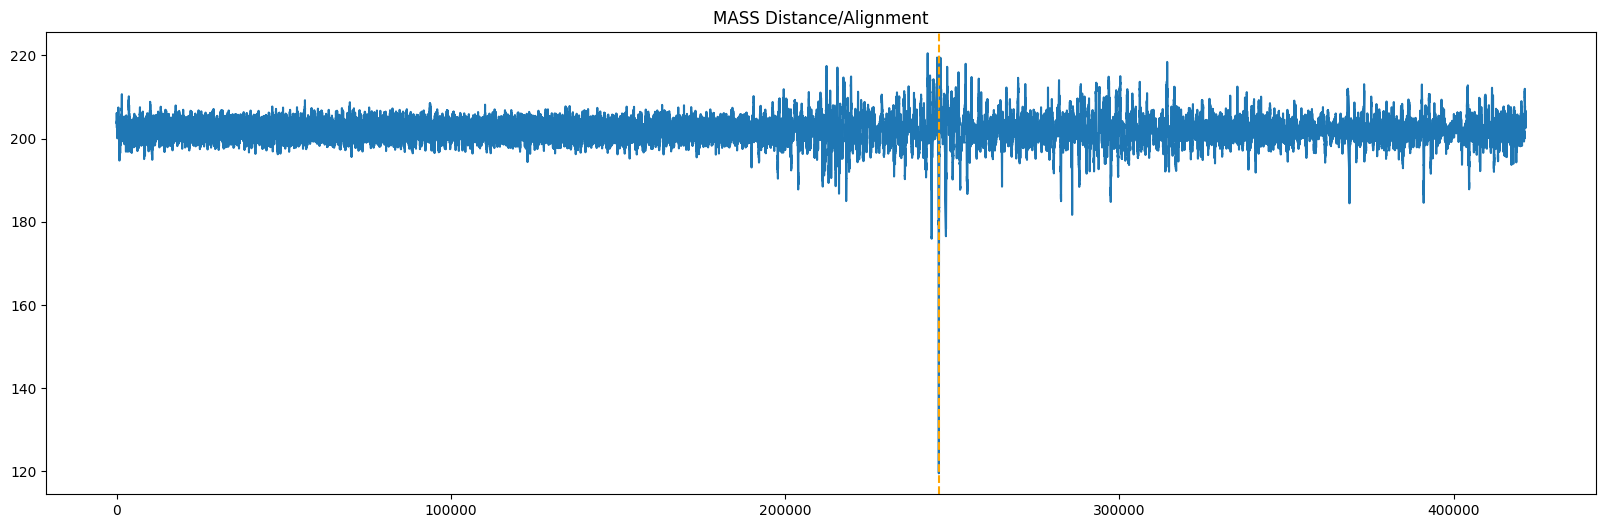

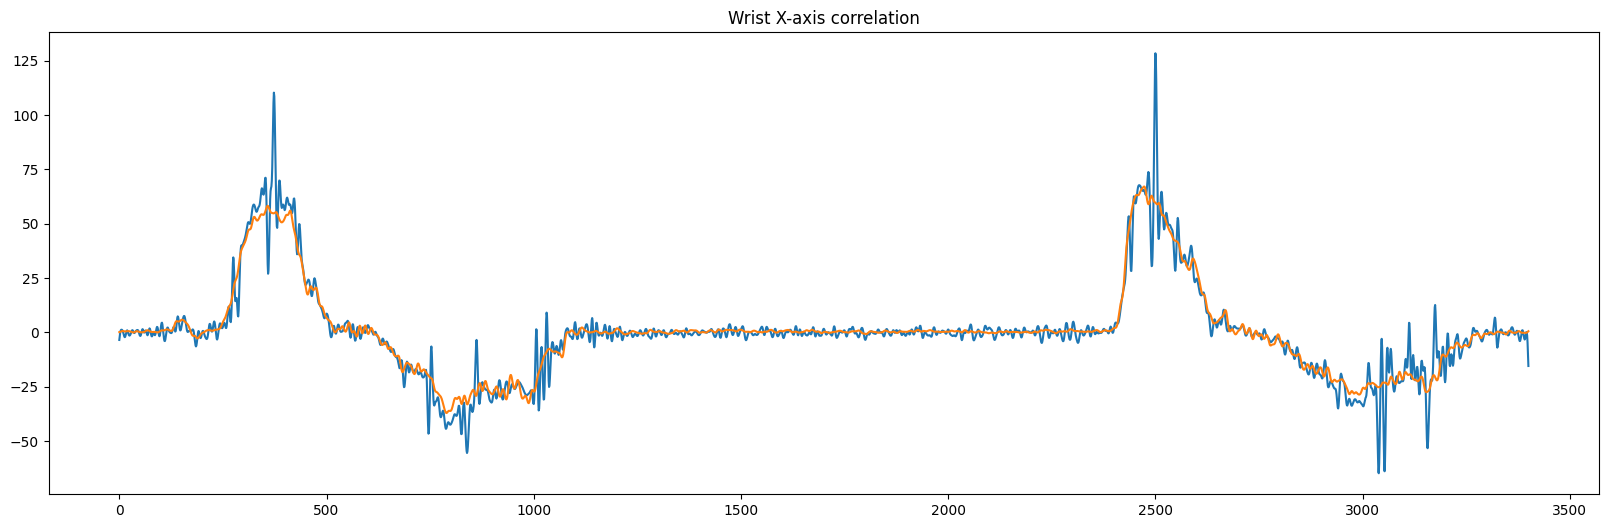

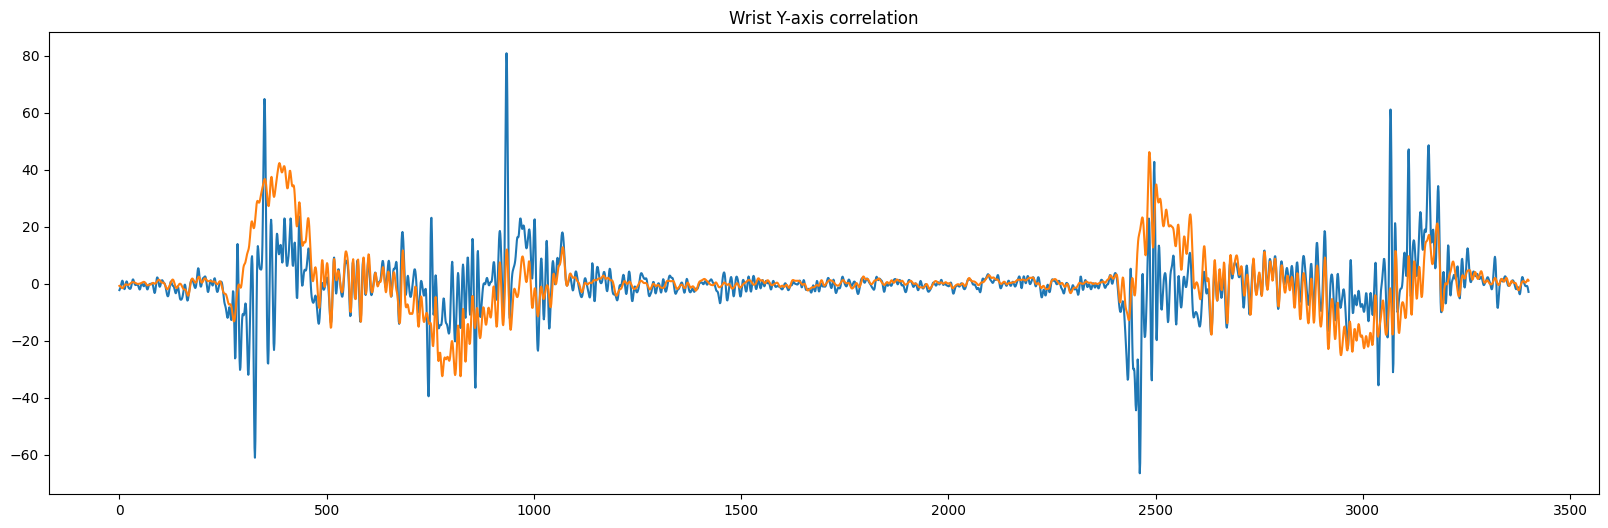

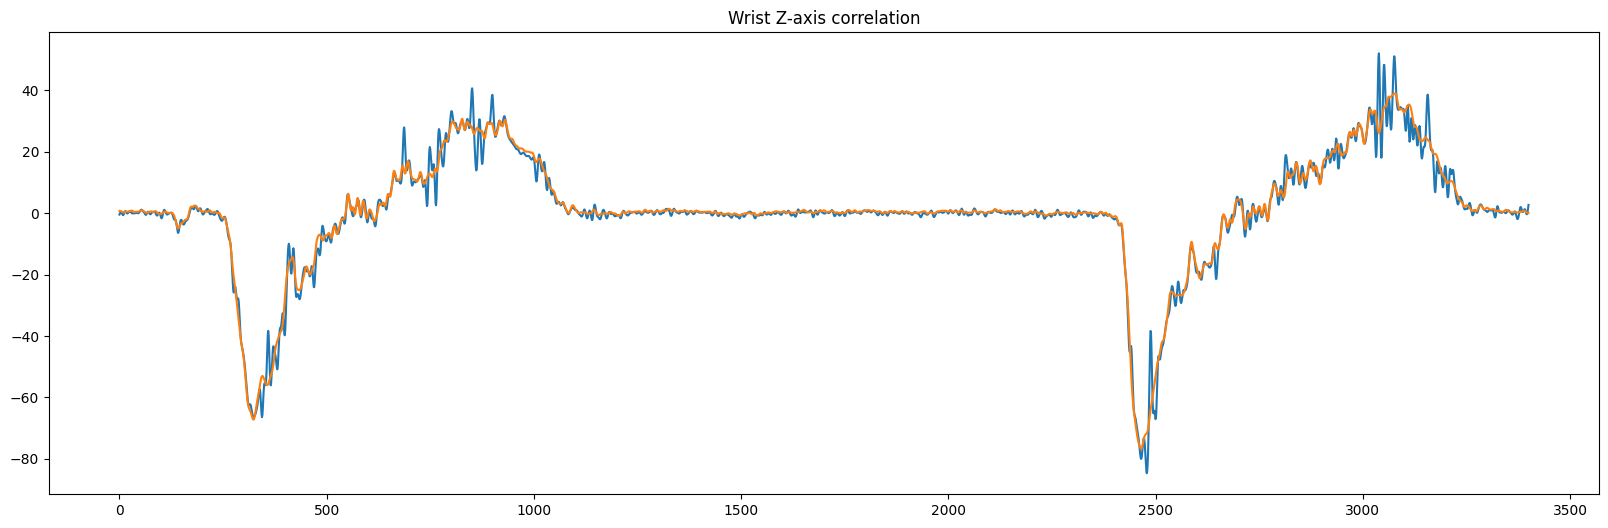

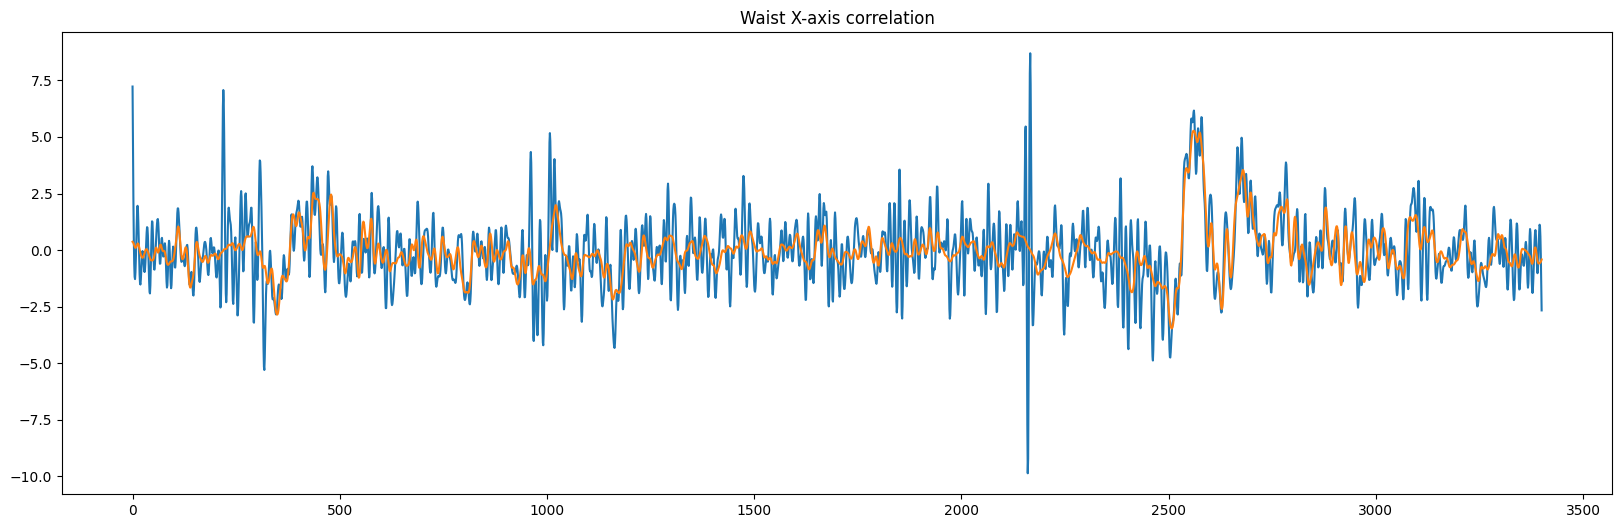

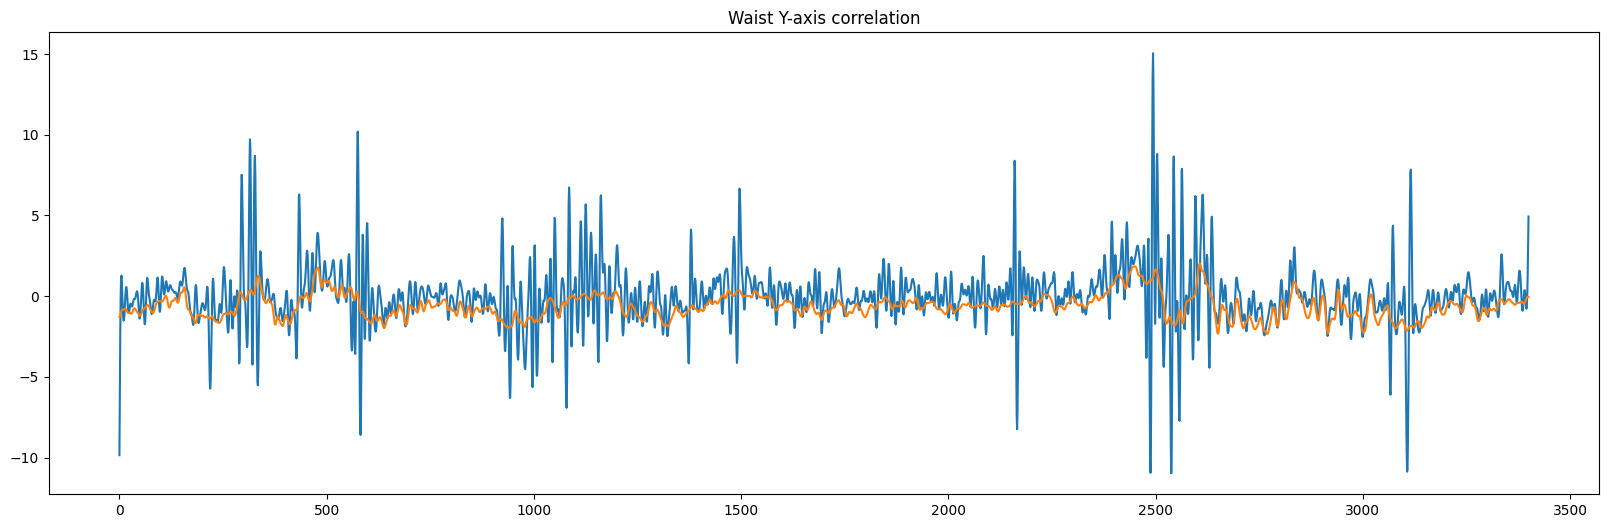

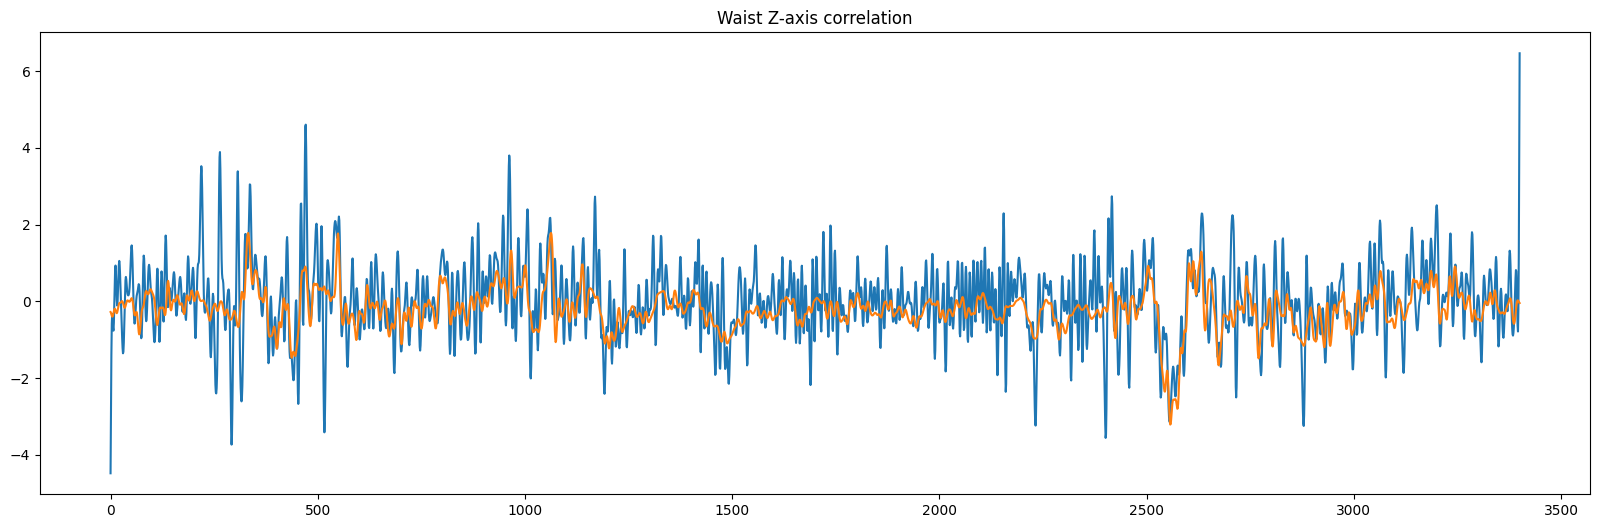


Number of NaNs = 0
Marker start time: [['TIME_STAMP' '2025-09-02, 14:11:32.122' 8296.9847578]]
marker_fs: 100.0
best_idx=np.int64(275702)
################## C:\Users\ac4jmi\Desktop\DMO4LNC\dmo4lnc-analysis\Dataset\PSP\864\Lab\\Motion Capture Data\10m_walk.tsv ##################


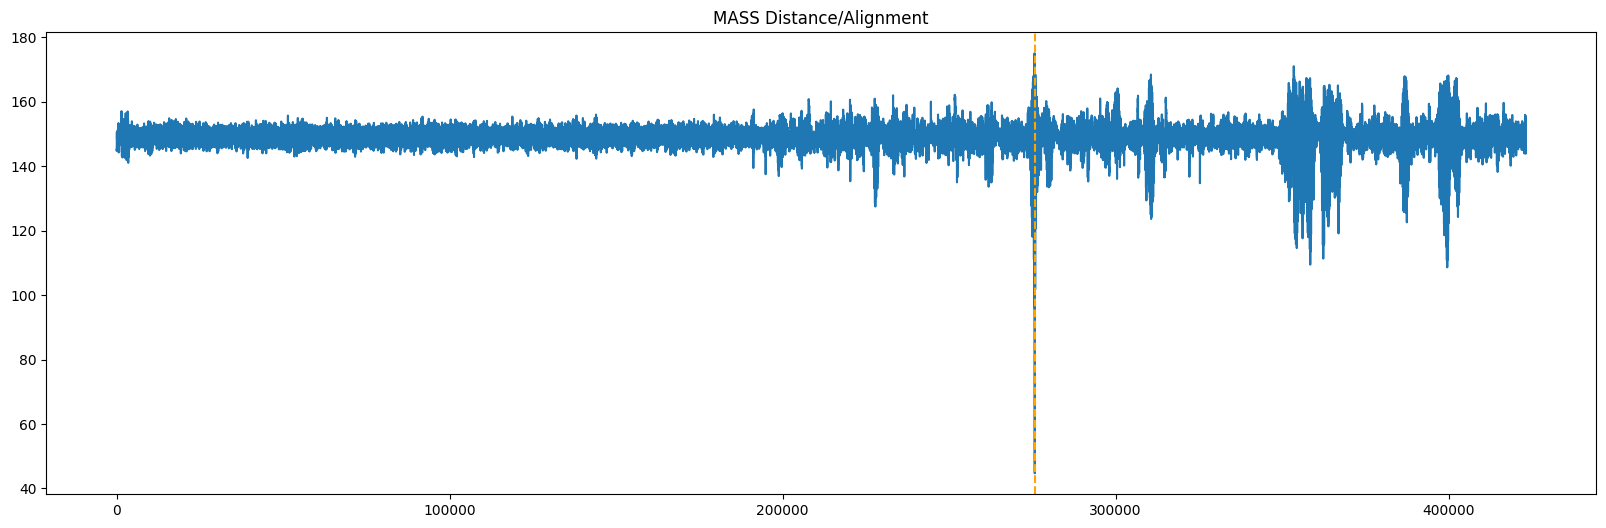

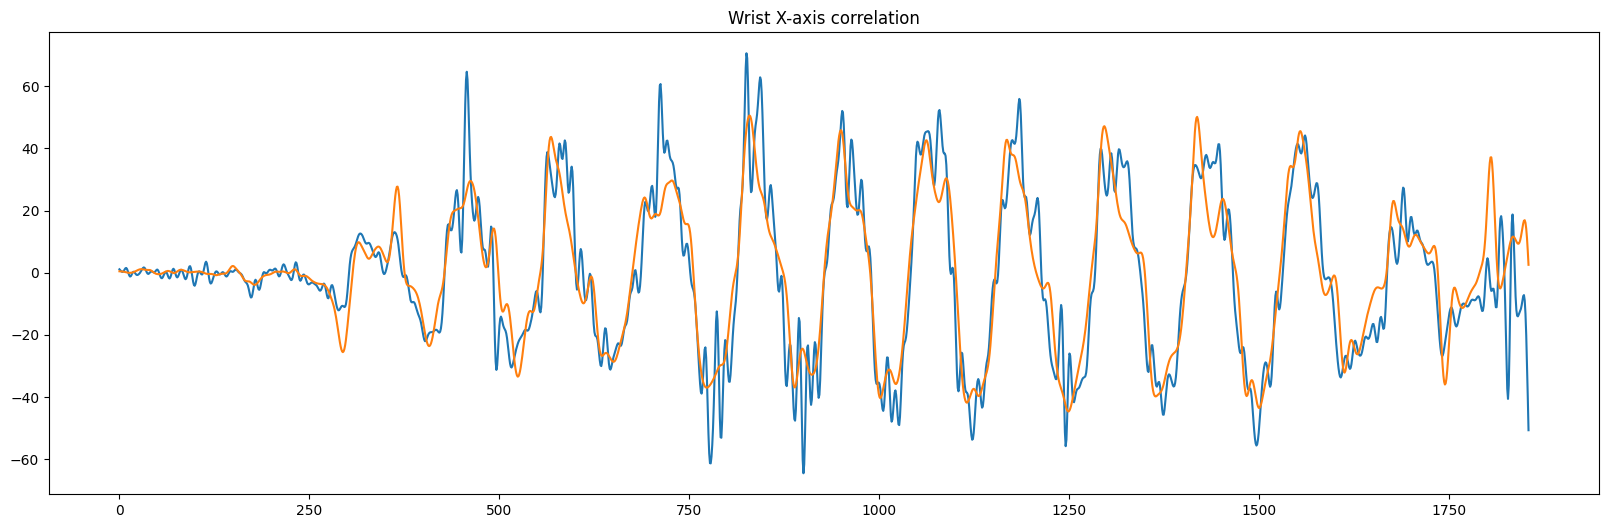

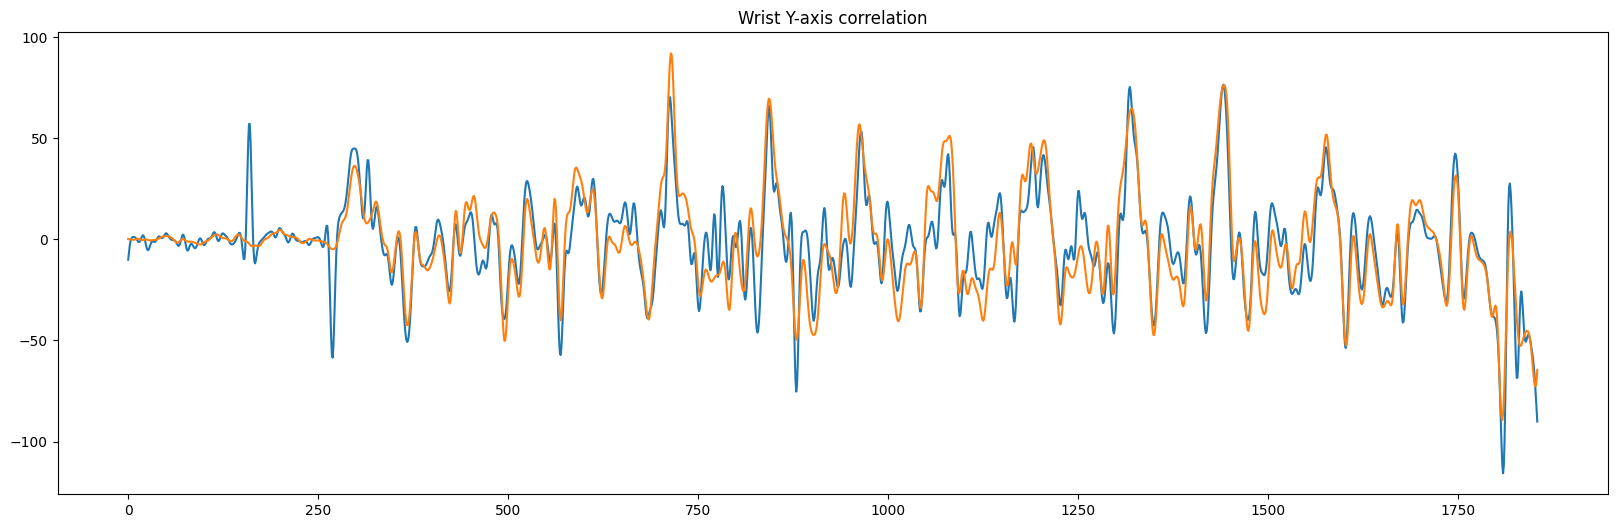

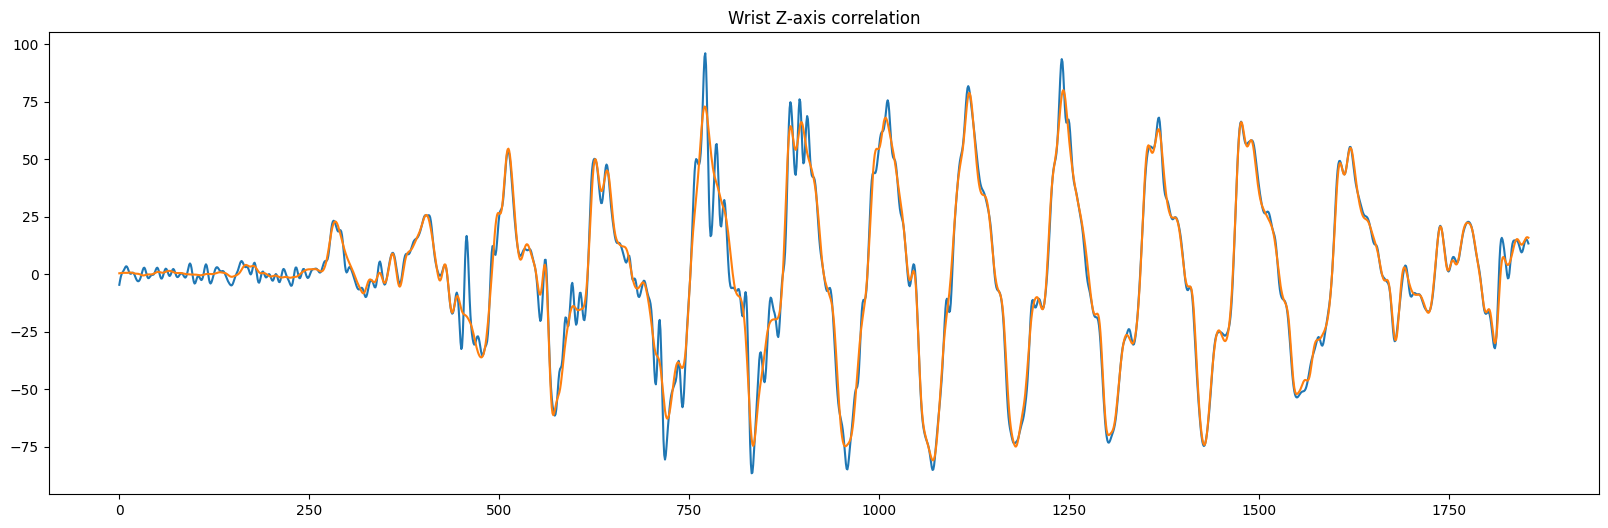

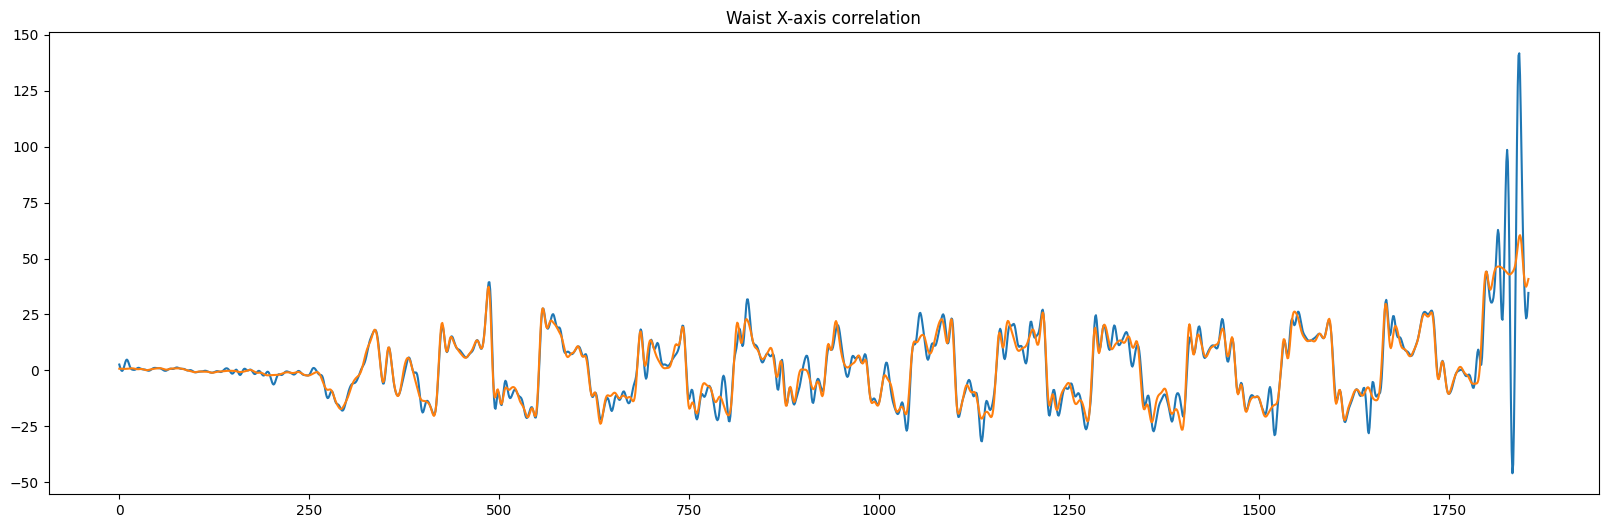

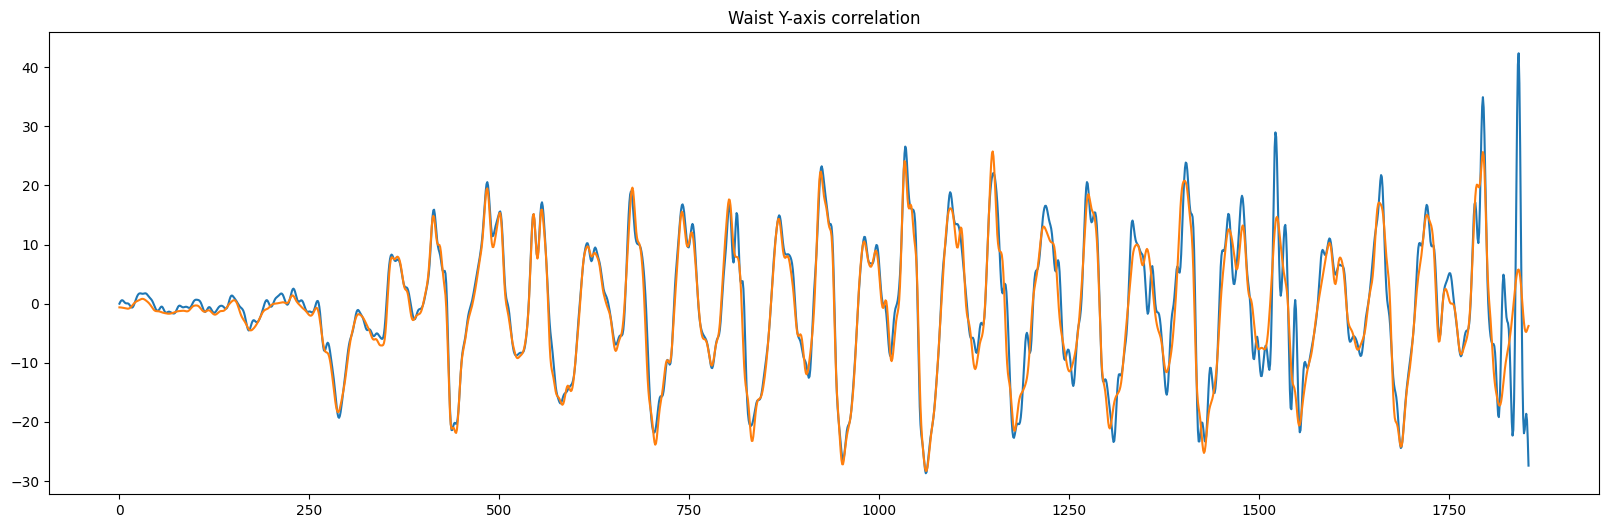

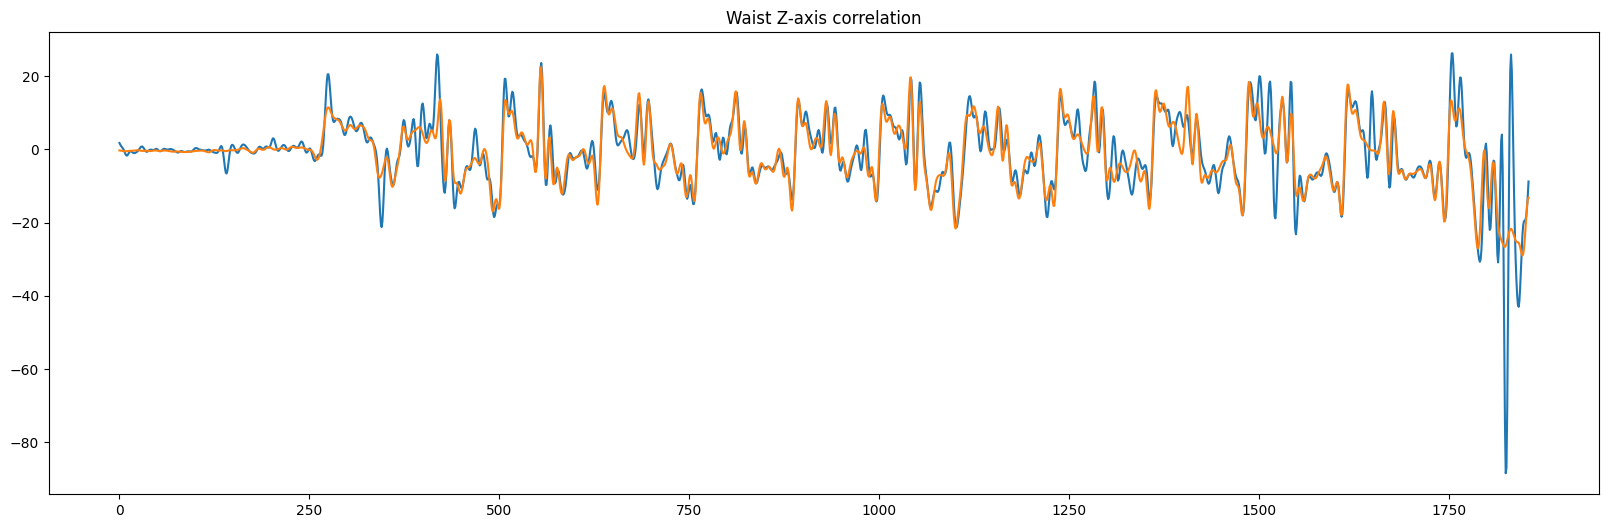


Number of NaNs = 0
Marker start time: [['TIME_STAMP' '2025-09-02, 14:12:16.525' 8341.3883309]]
marker_fs: 100.0
best_idx=np.int64(280132)
################## C:\Users\ac4jmi\Desktop\DMO4LNC\dmo4lnc-analysis\Dataset\PSP\864\Lab\\Motion Capture Data\10m_walk_bag.tsv ##################


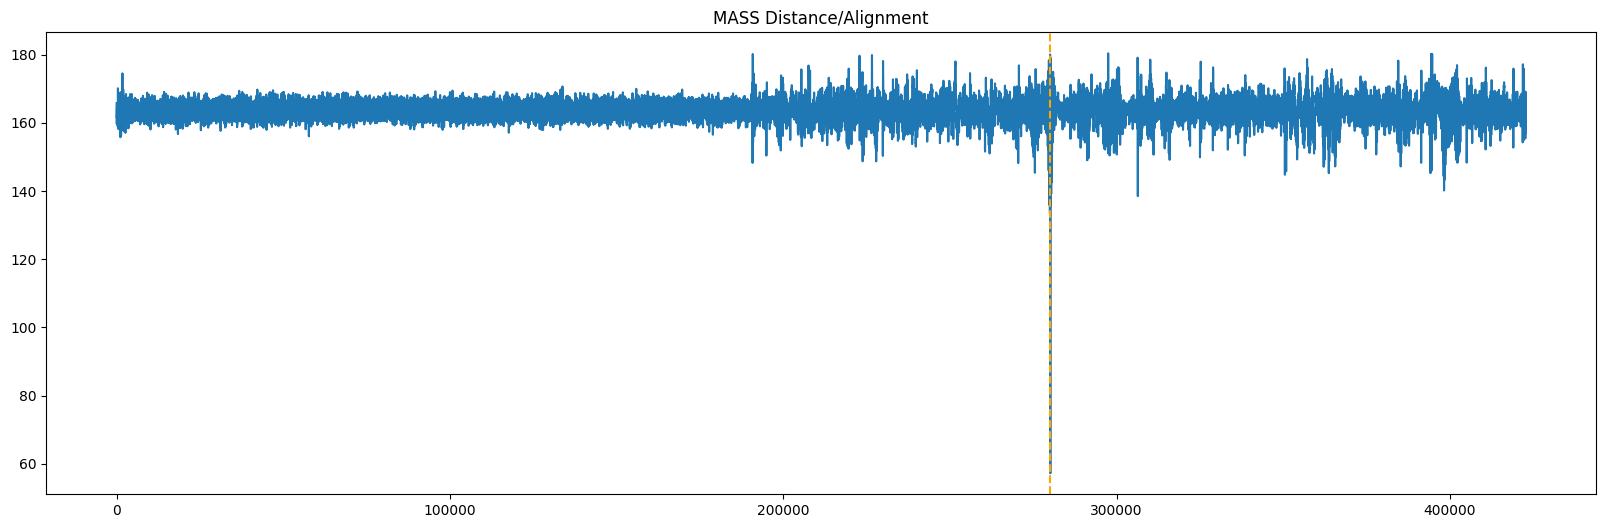

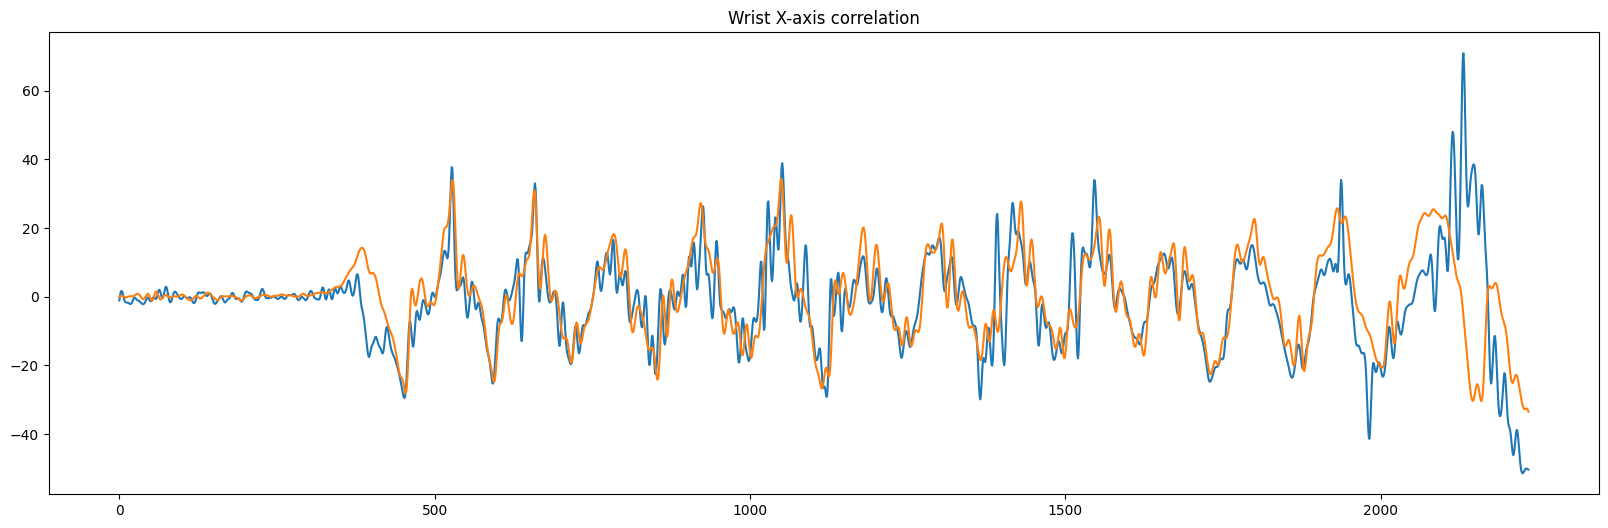

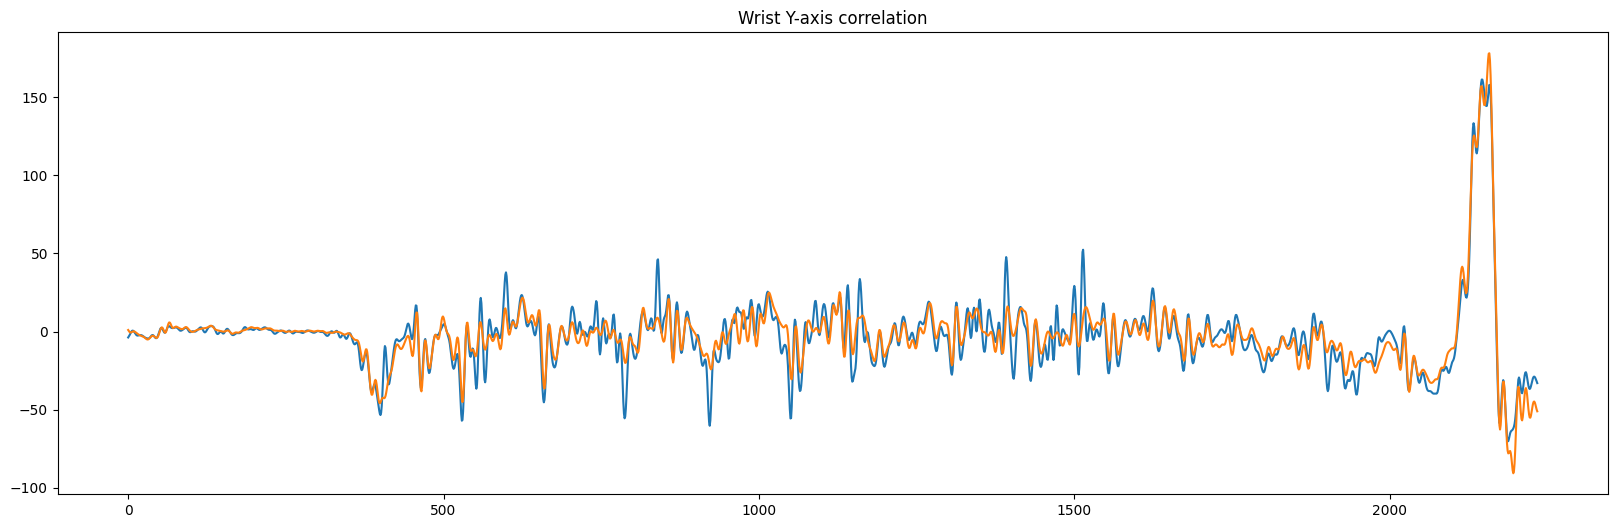

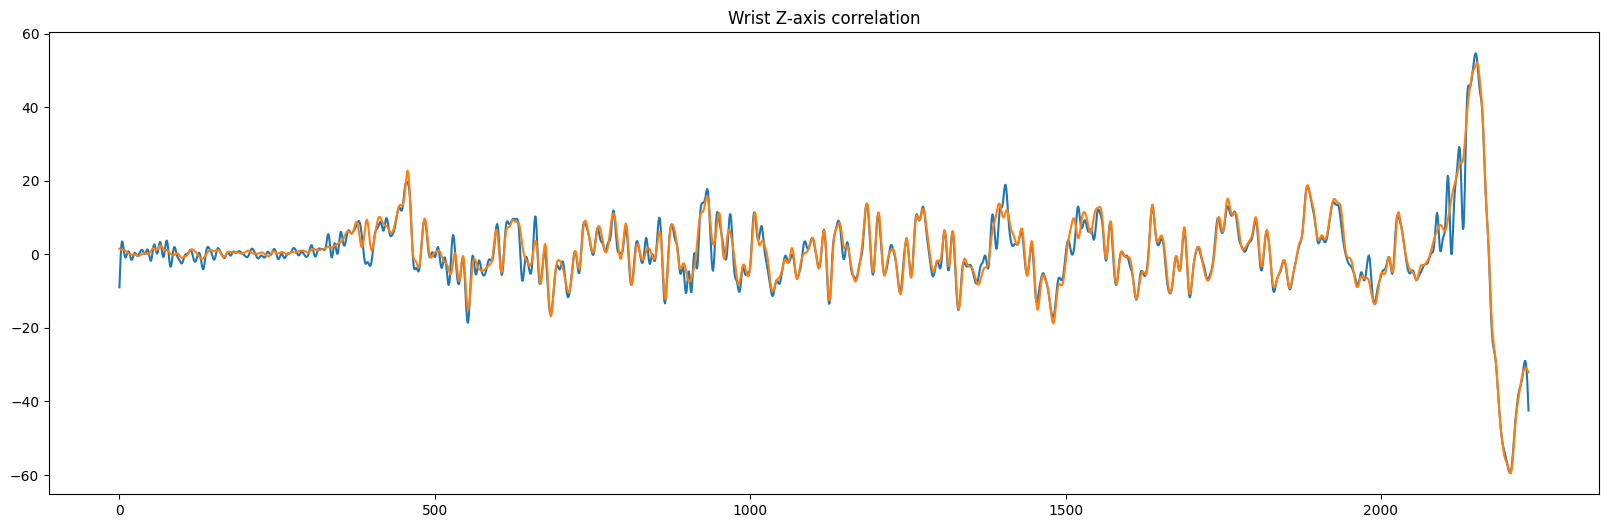

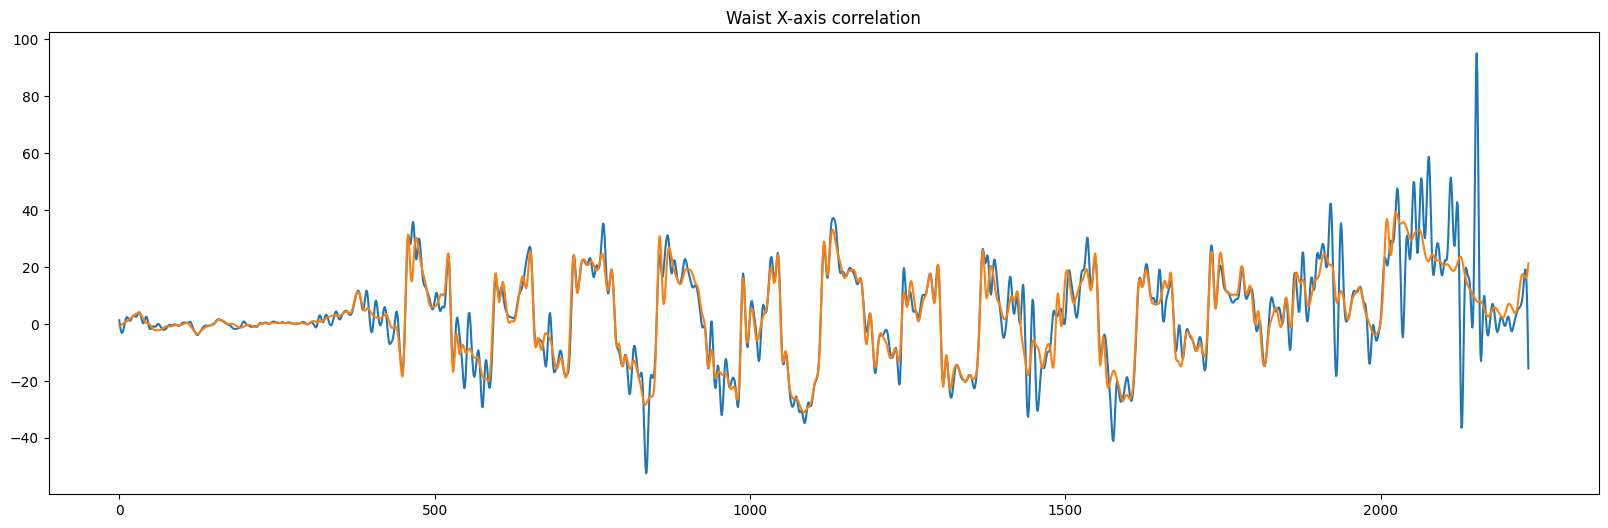

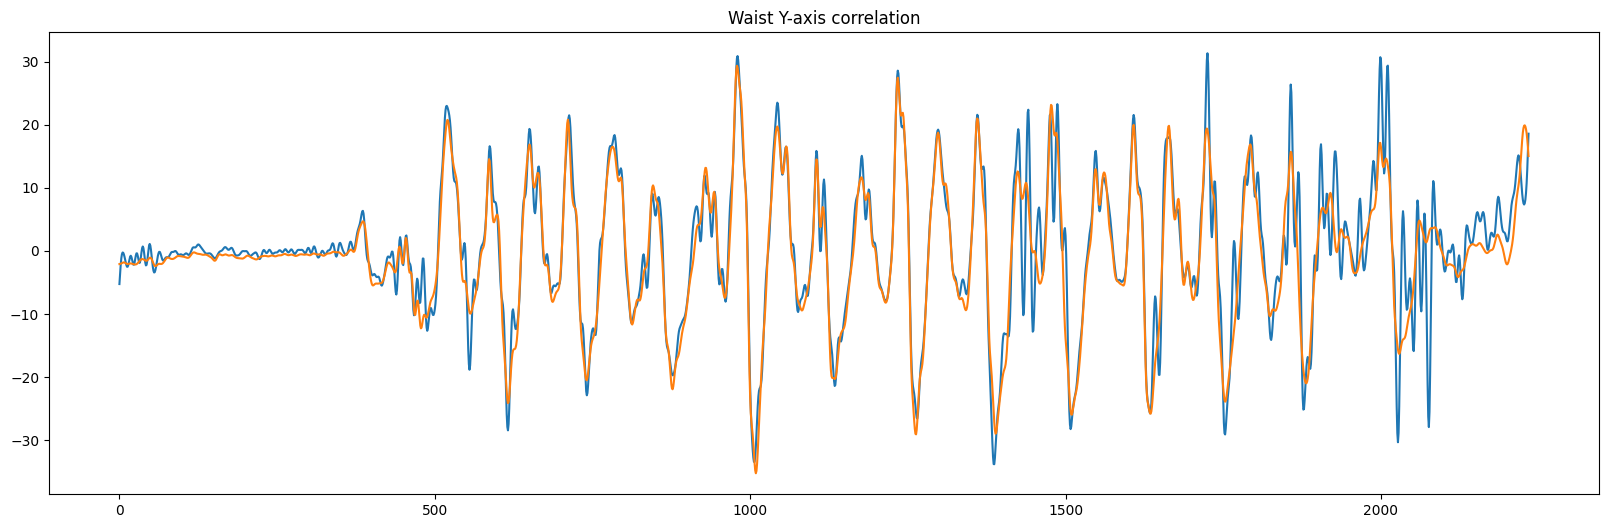

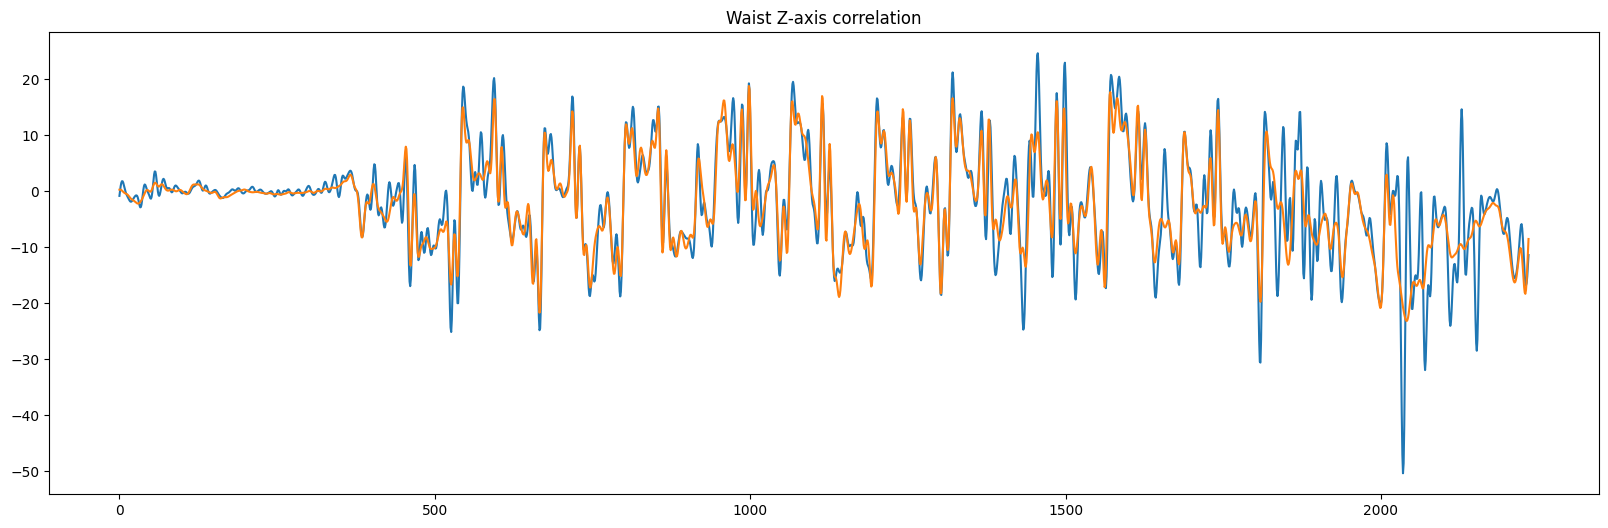


Number of NaNs = 0
Marker start time: [['TIME_STAMP' '2025-09-02, 14:14:34.962' 8479.825508]]
marker_fs: 100.0
best_idx=np.int64(296930)
################## C:\Users\ac4jmi\Desktop\DMO4LNC\dmo4lnc-analysis\Dataset\PSP\864\Lab\\Motion Capture Data\10m_walk_utensils.tsv ##################


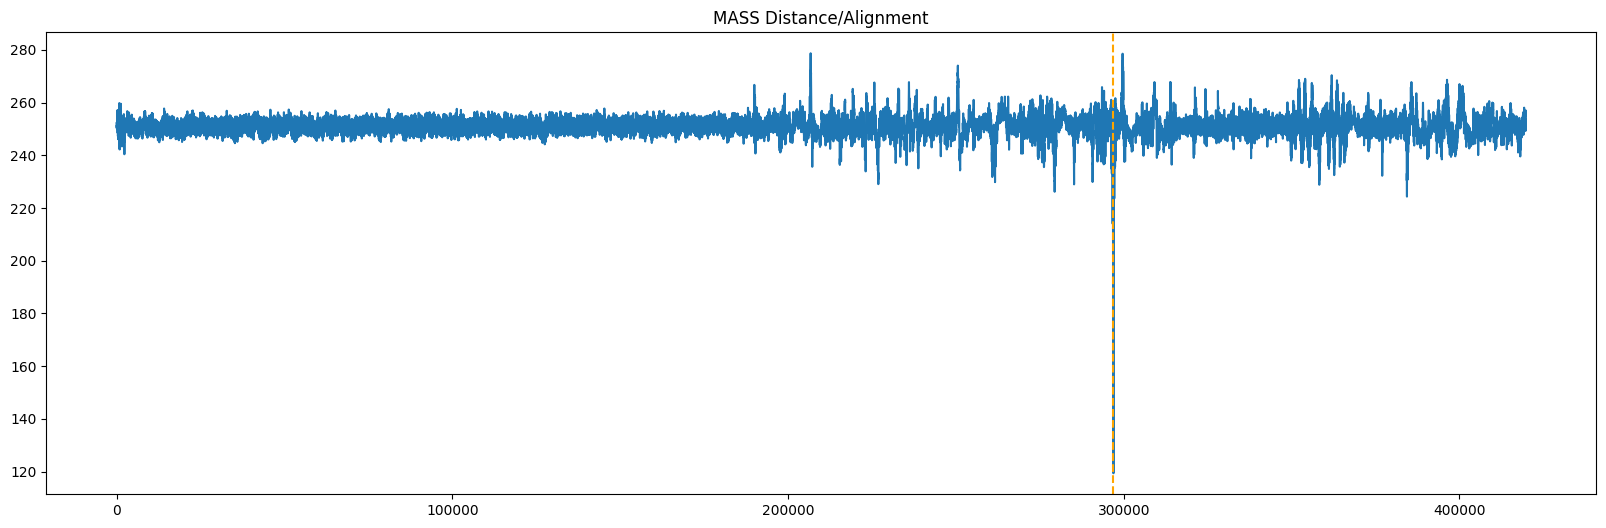

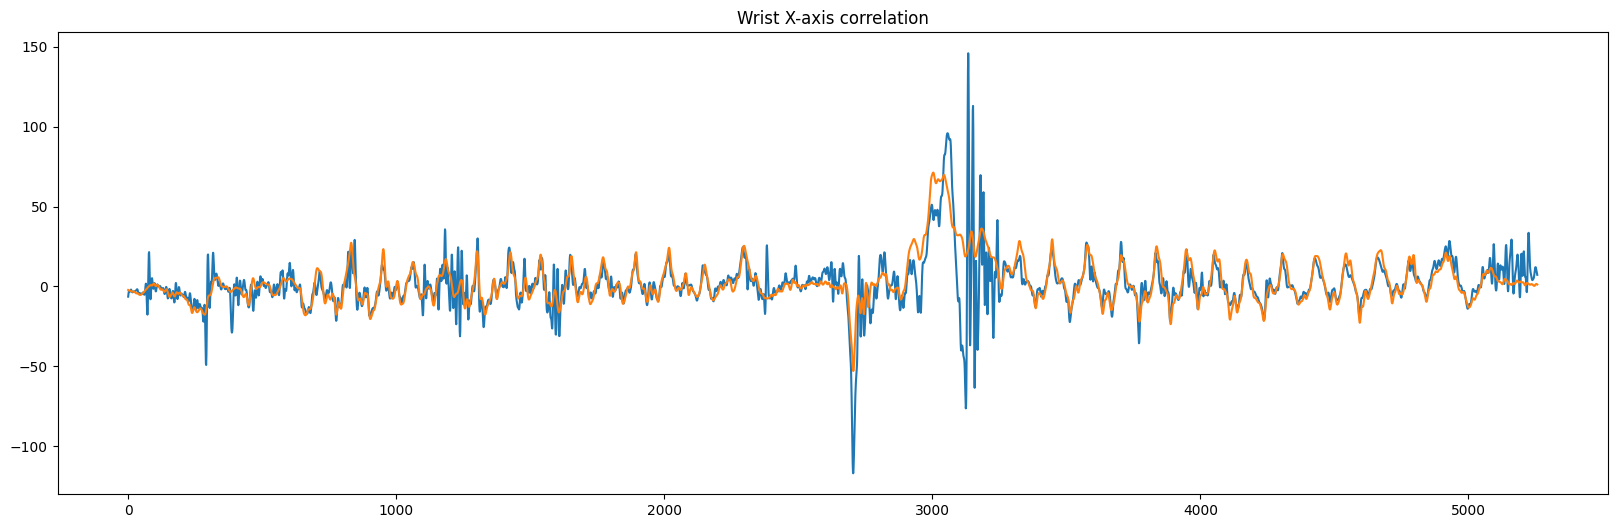

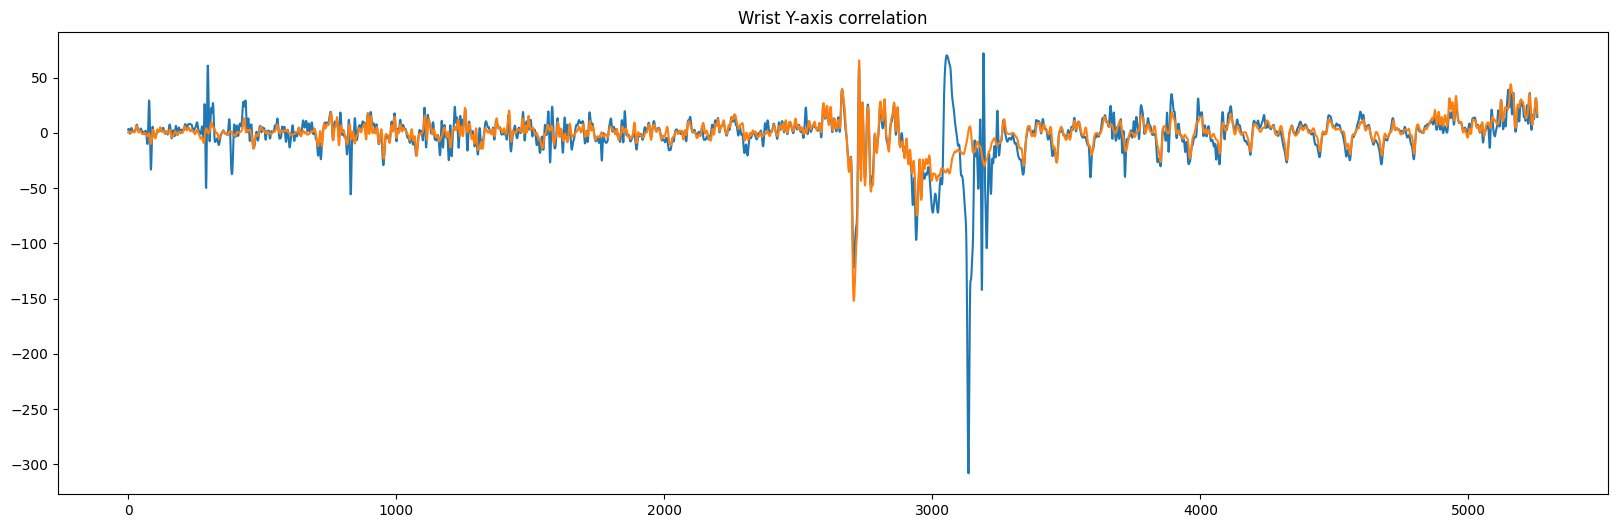

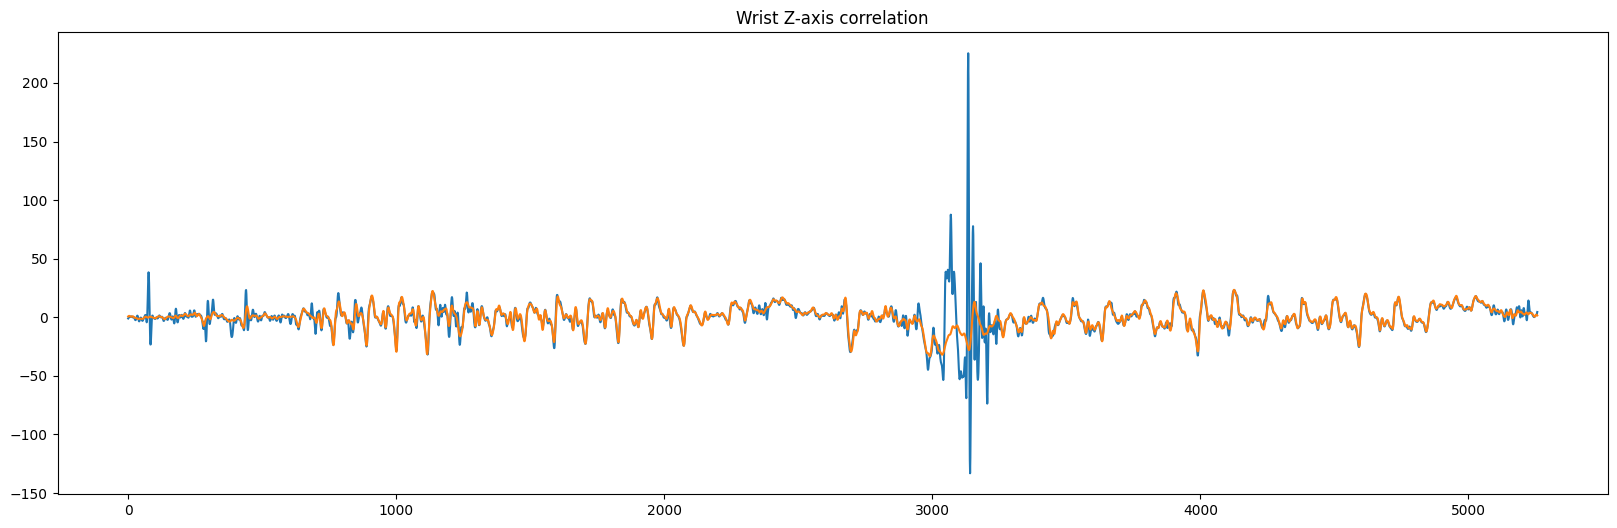

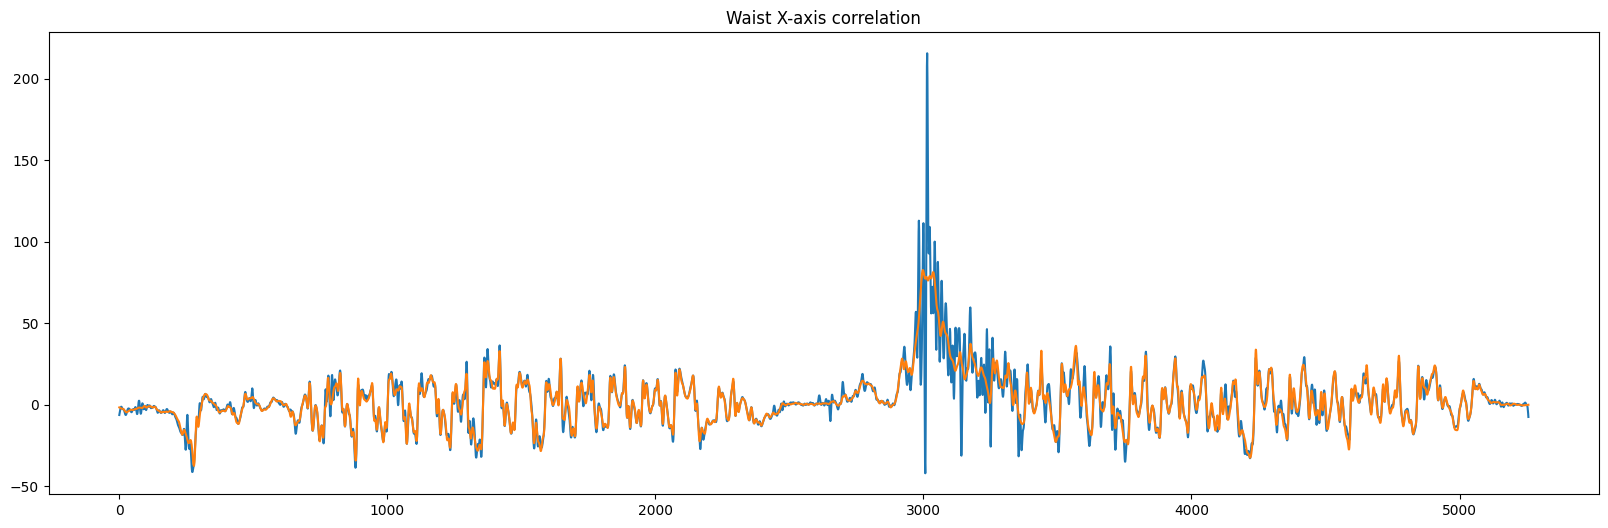

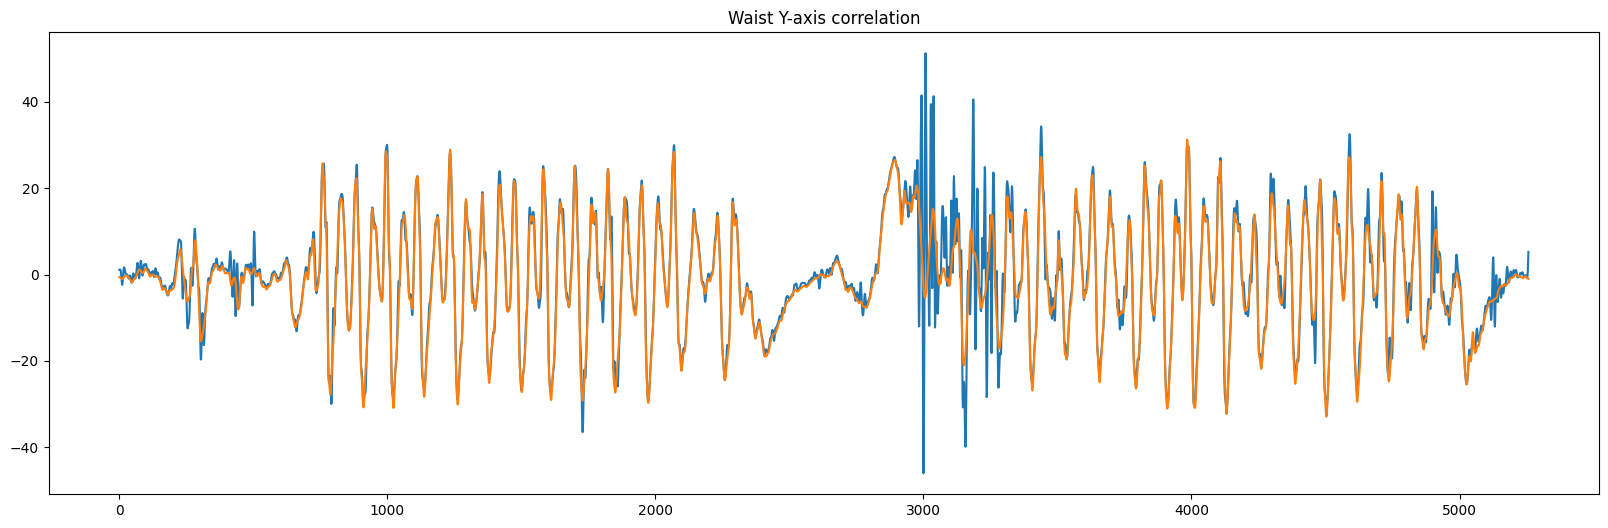

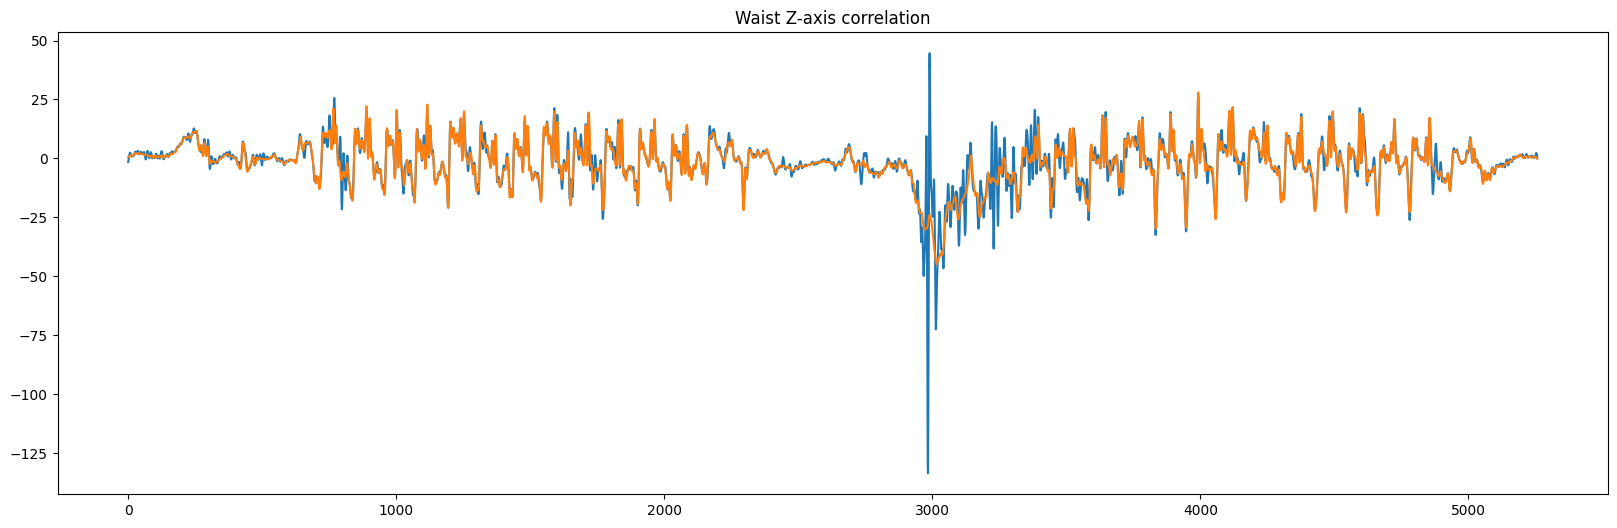


Number of NaNs = 0
Marker start time: [['TIME_STAMP' '2025-09-02, 14:17:14.472' 8639.334768]]
marker_fs: 100.0
best_idx=np.int64(309926)
################## C:\Users\ac4jmi\Desktop\DMO4LNC\dmo4lnc-analysis\Dataset\PSP\864\Lab\\Motion Capture Data\10m_walk_step.tsv ##################


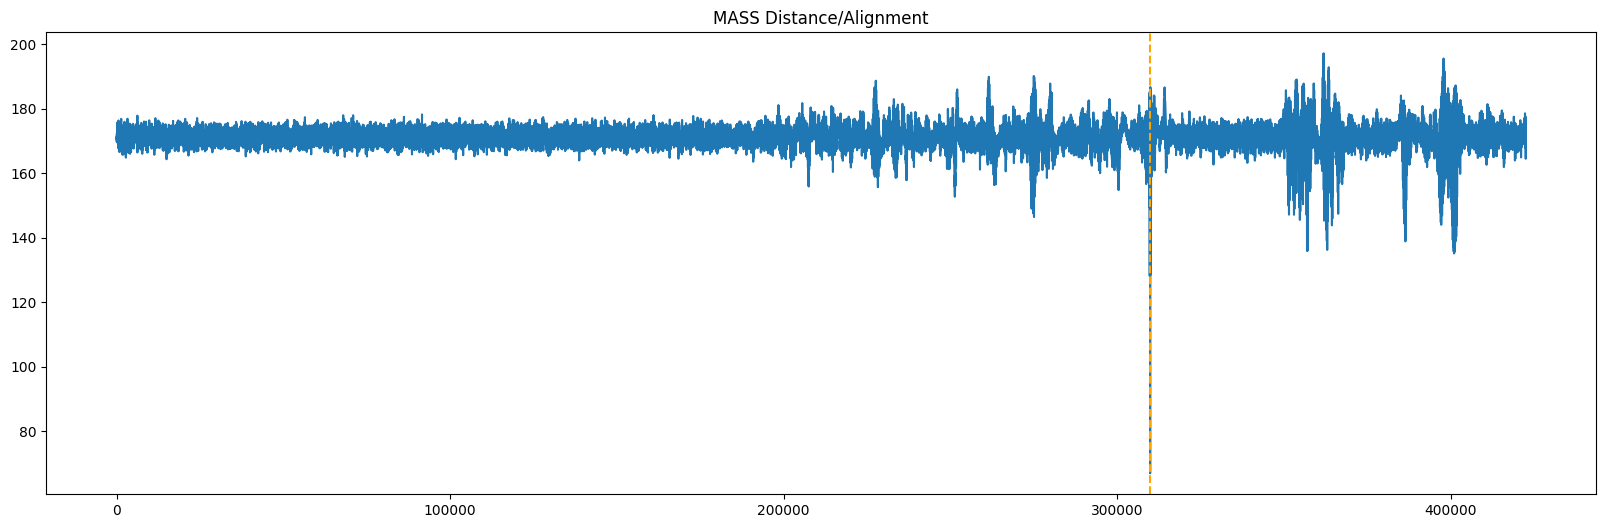

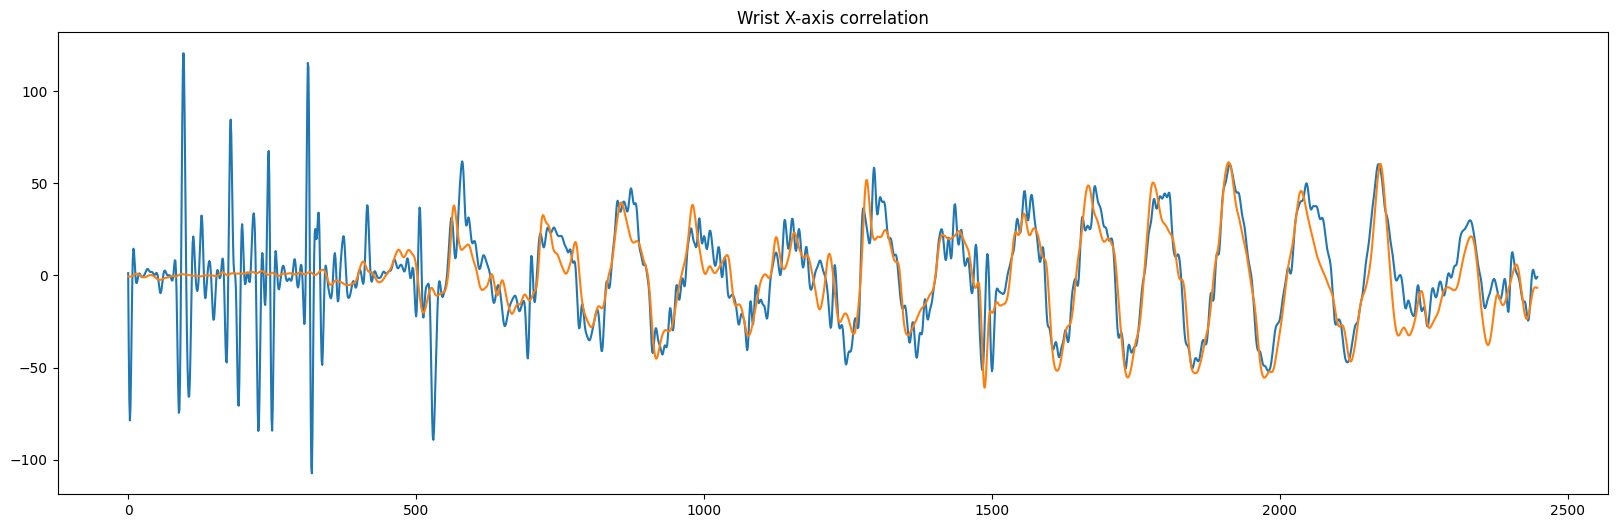

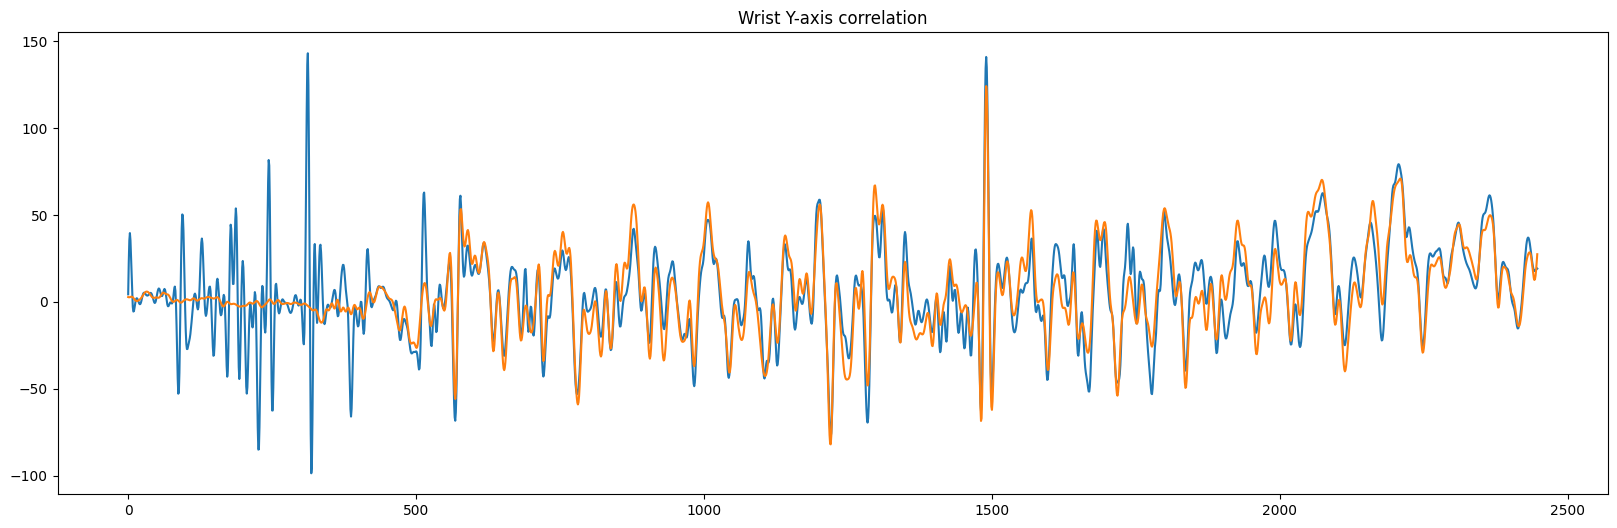

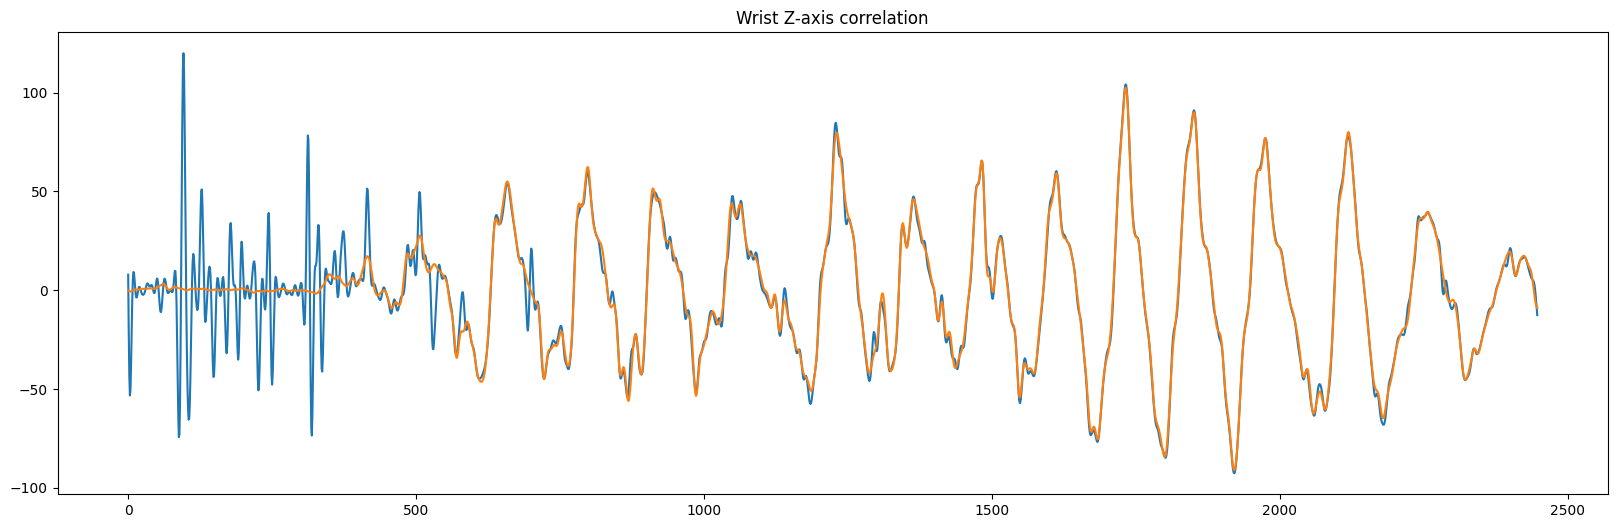

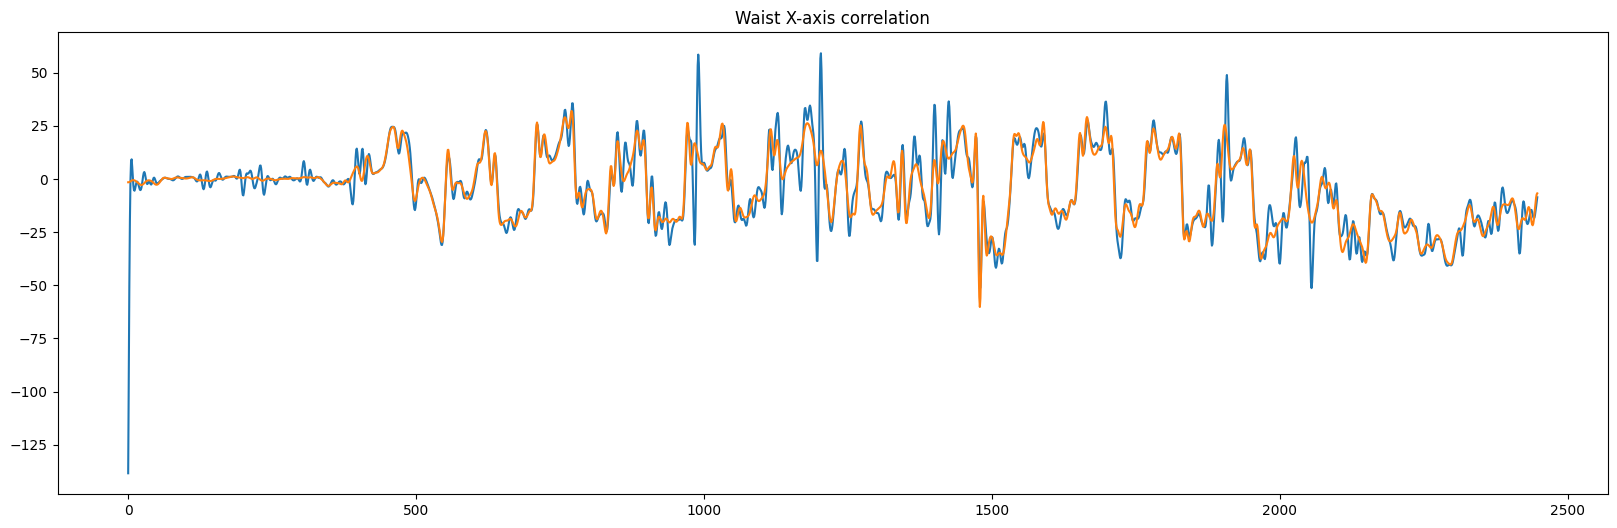

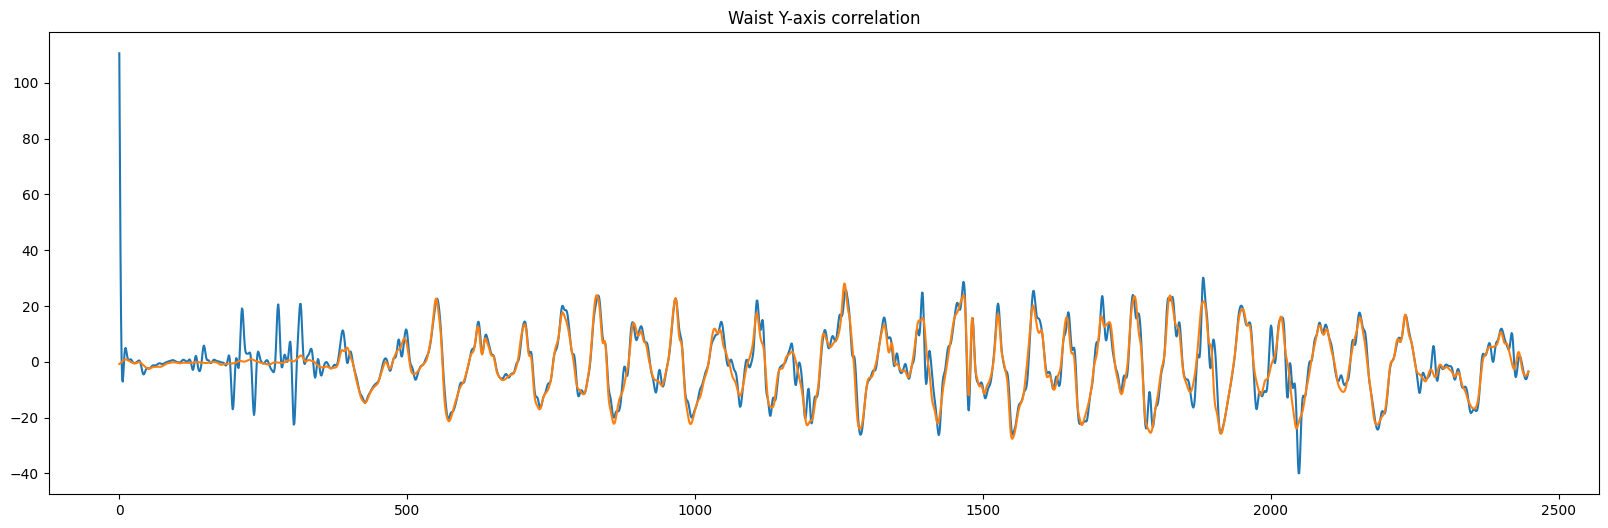

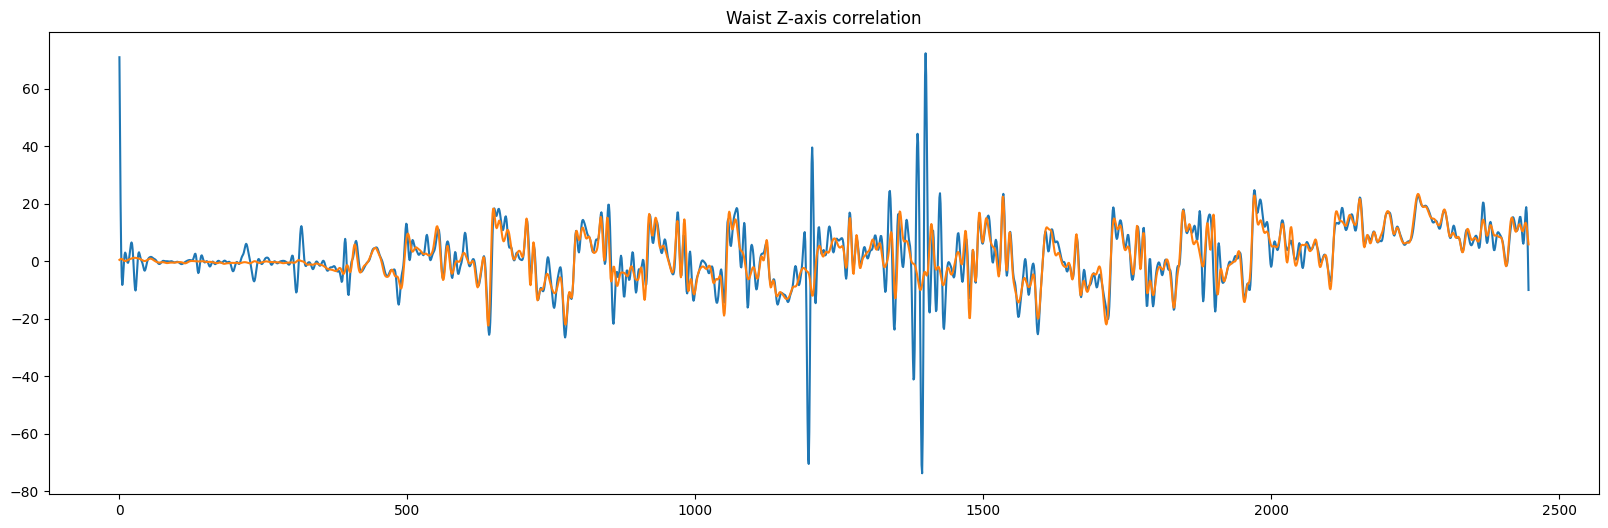


Number of NaNs = 0
Marker start time: [['TIME_STAMP' '2025-09-02, 14:09:14.066' 8158.9283728]]
marker_fs: 100.0
best_idx=np.int64(262094)
################## C:\Users\ac4jmi\Desktop\DMO4LNC\dmo4lnc-analysis\Dataset\PSP\864\Lab\\Motion Capture Data\tug.tsv ##################


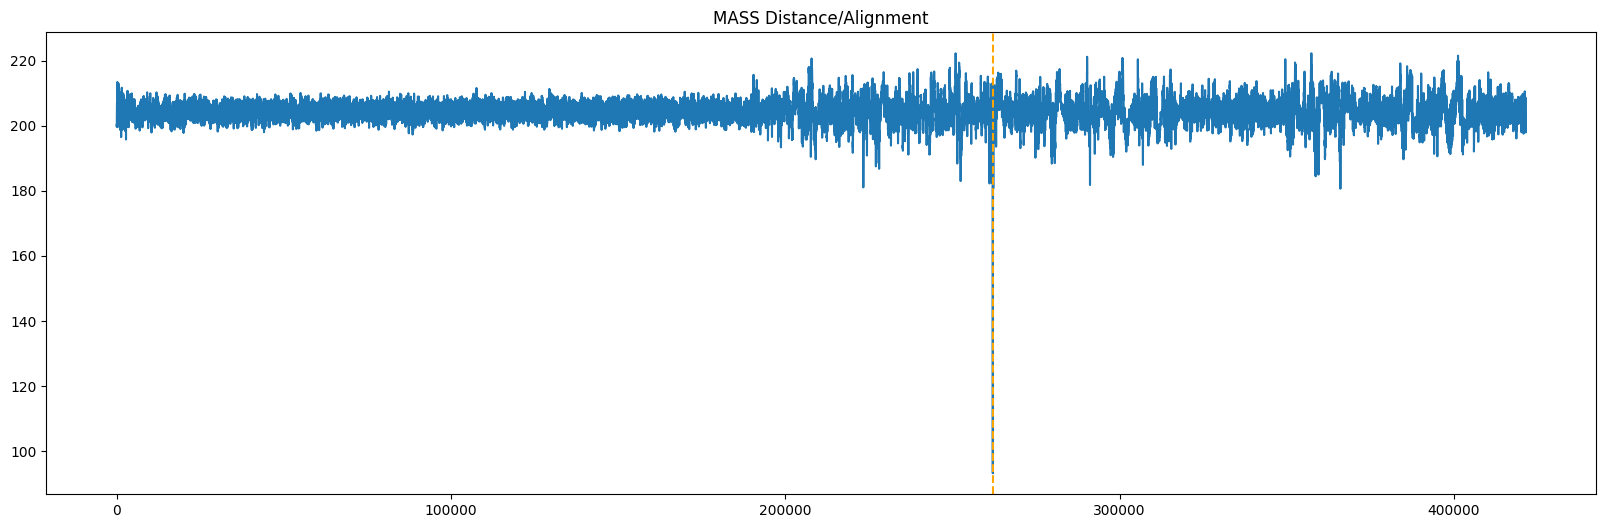

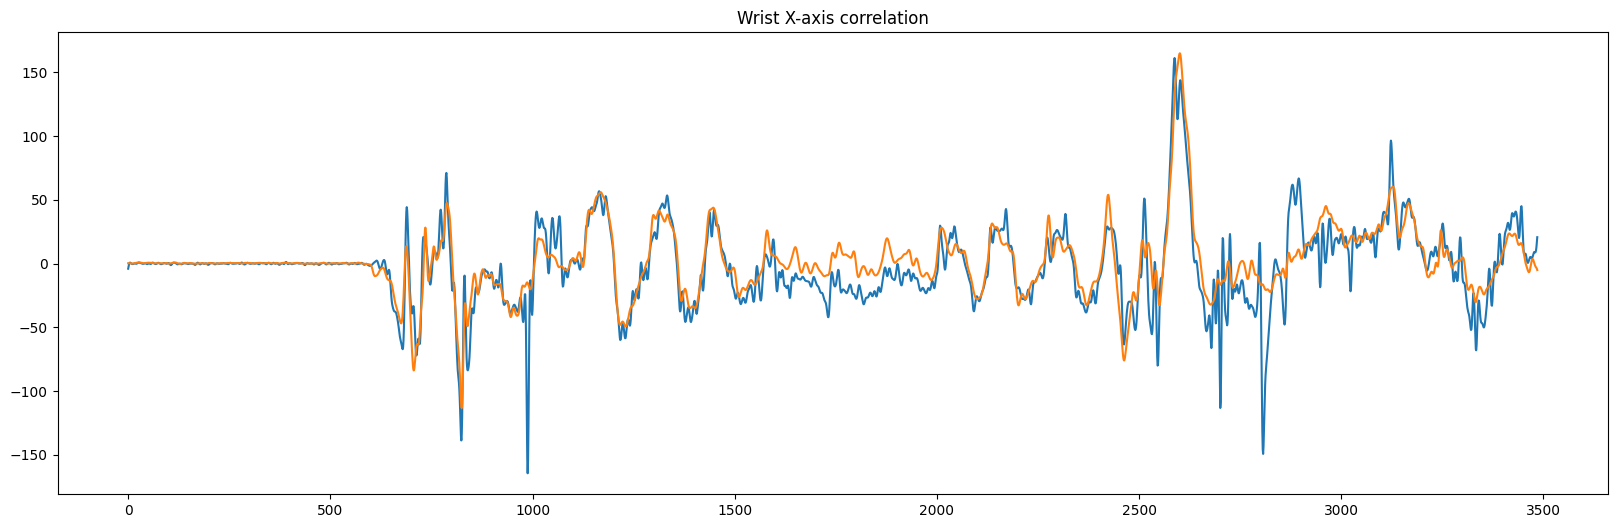

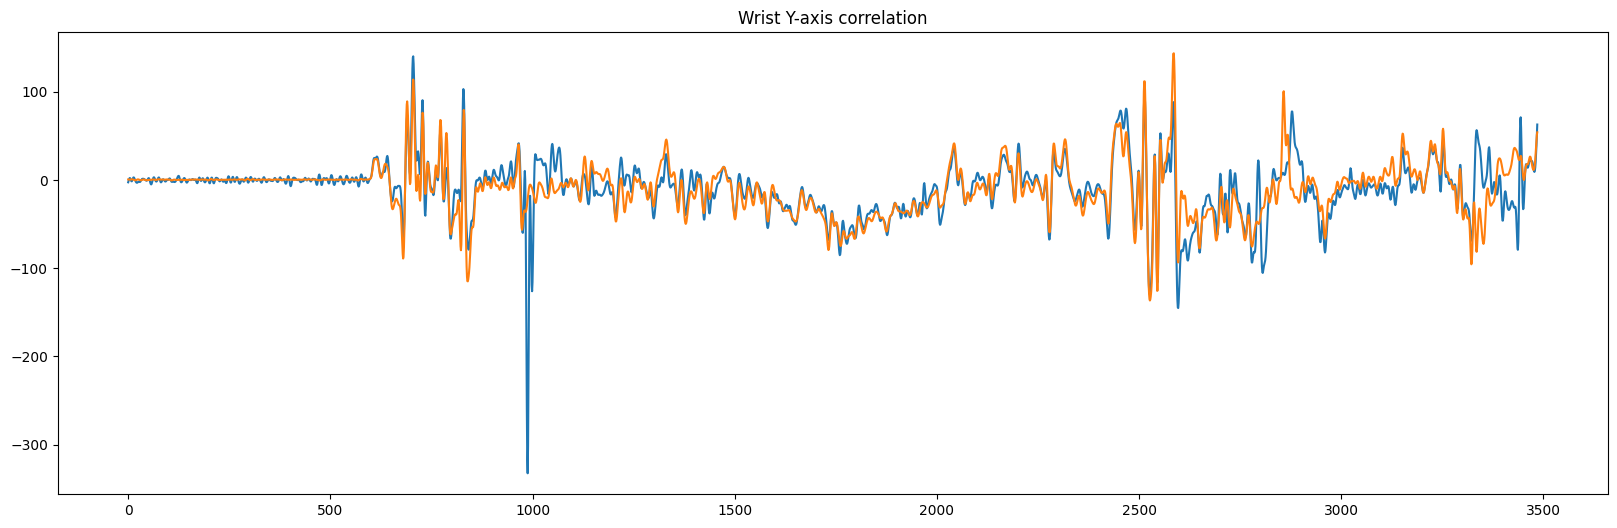

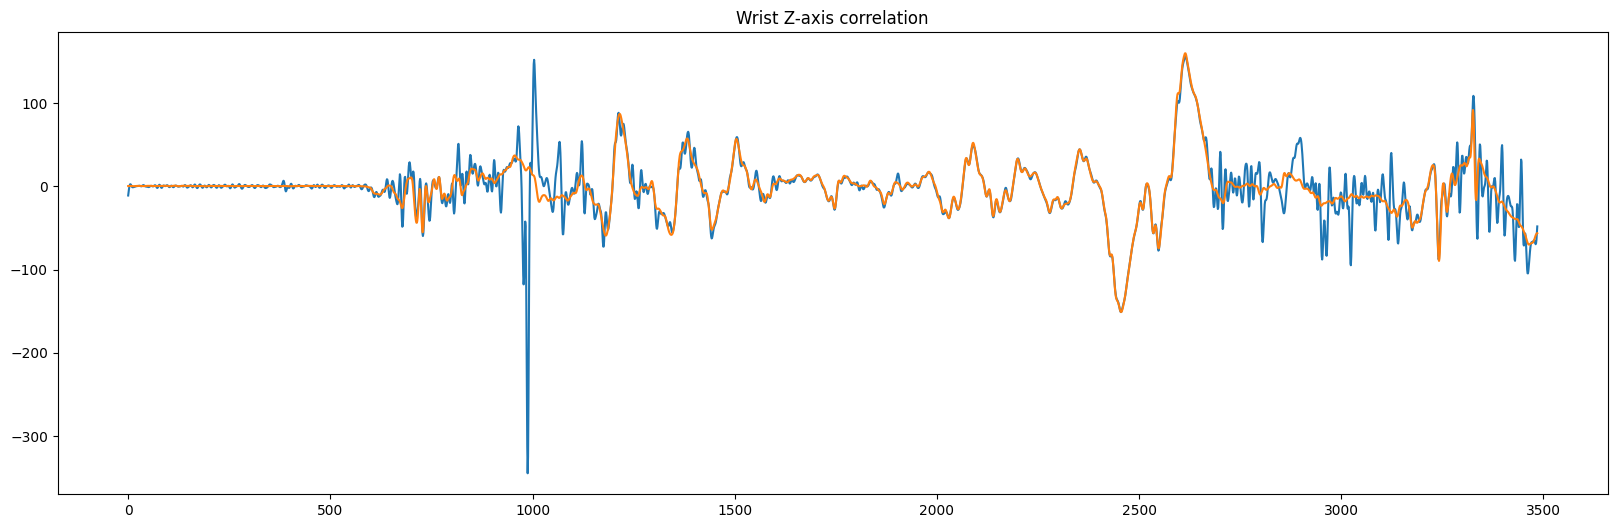

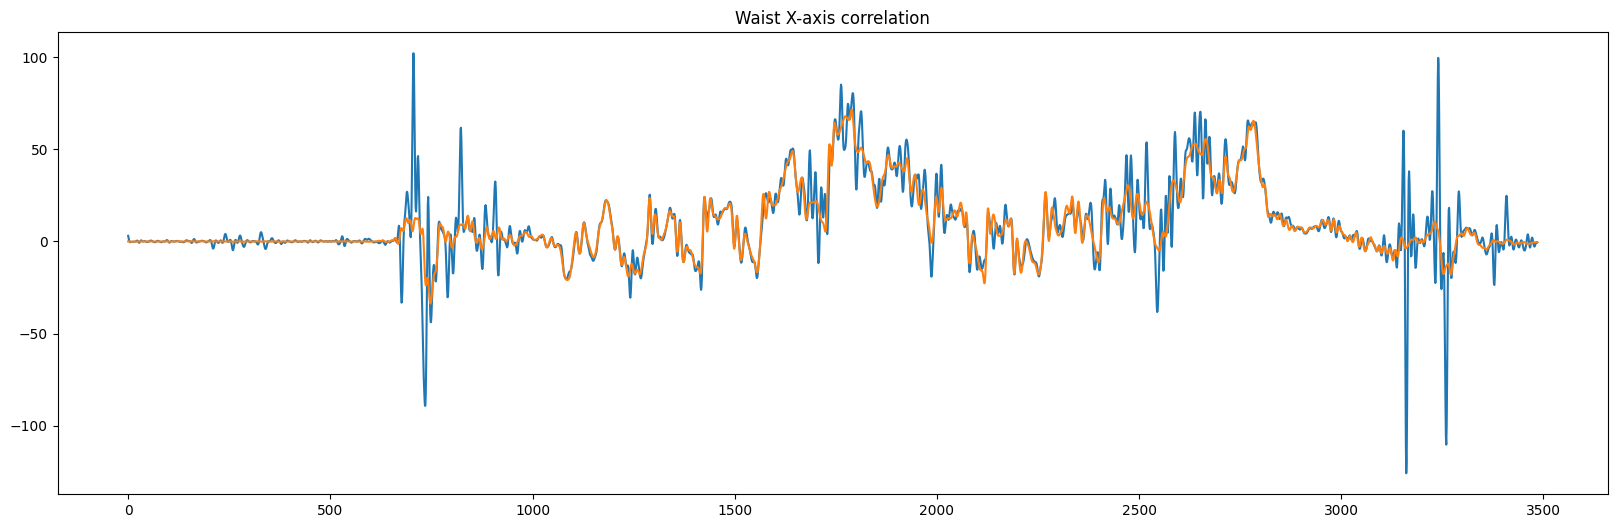

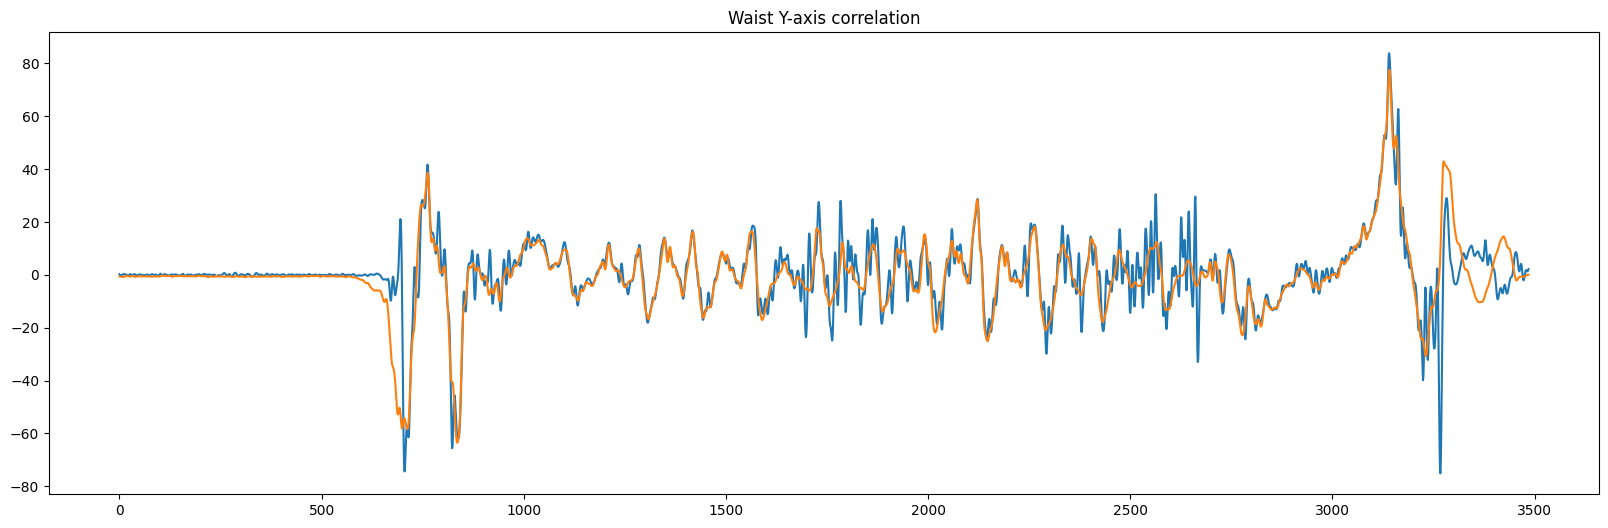

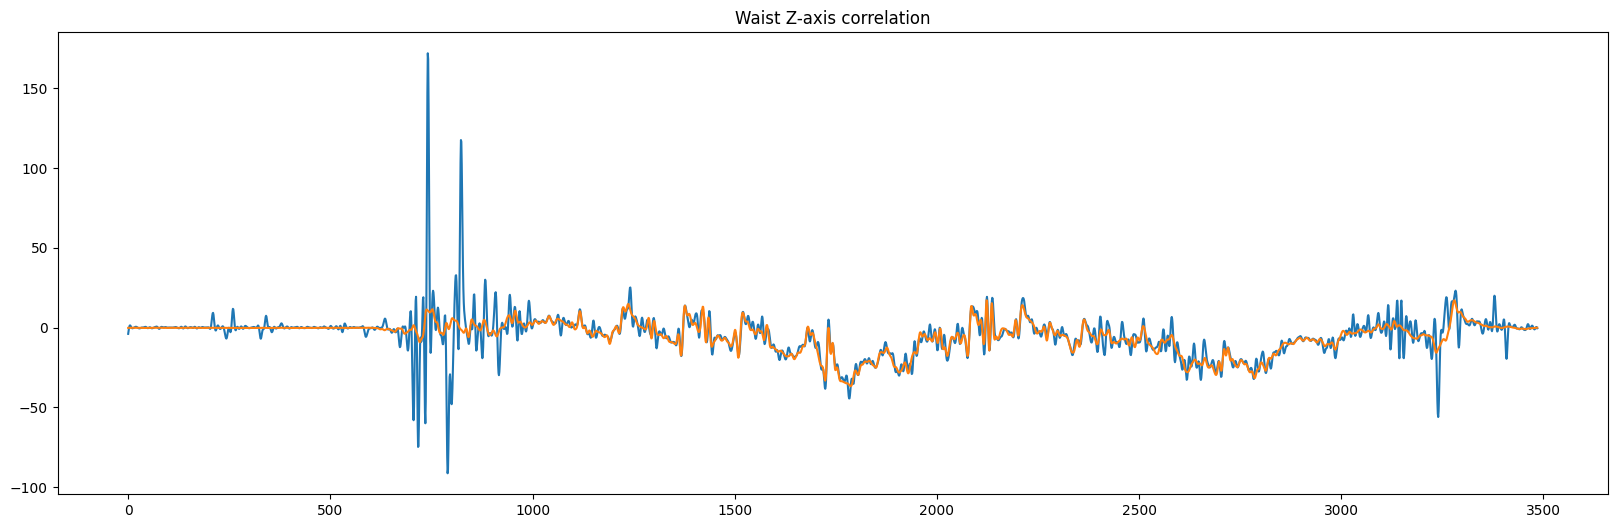


Number of NaNs = 0
Marker start time: [['TIME_STAMP' '2025-09-02, 14:24:36.246' 9081.1086351]]
marker_fs: 100.0
best_idx=np.int64(354249)
################## C:\Users\ac4jmi\Desktop\DMO4LNC\dmo4lnc-analysis\Dataset\PSP\864\Lab\\Motion Capture Data\TCW.tsv ##################


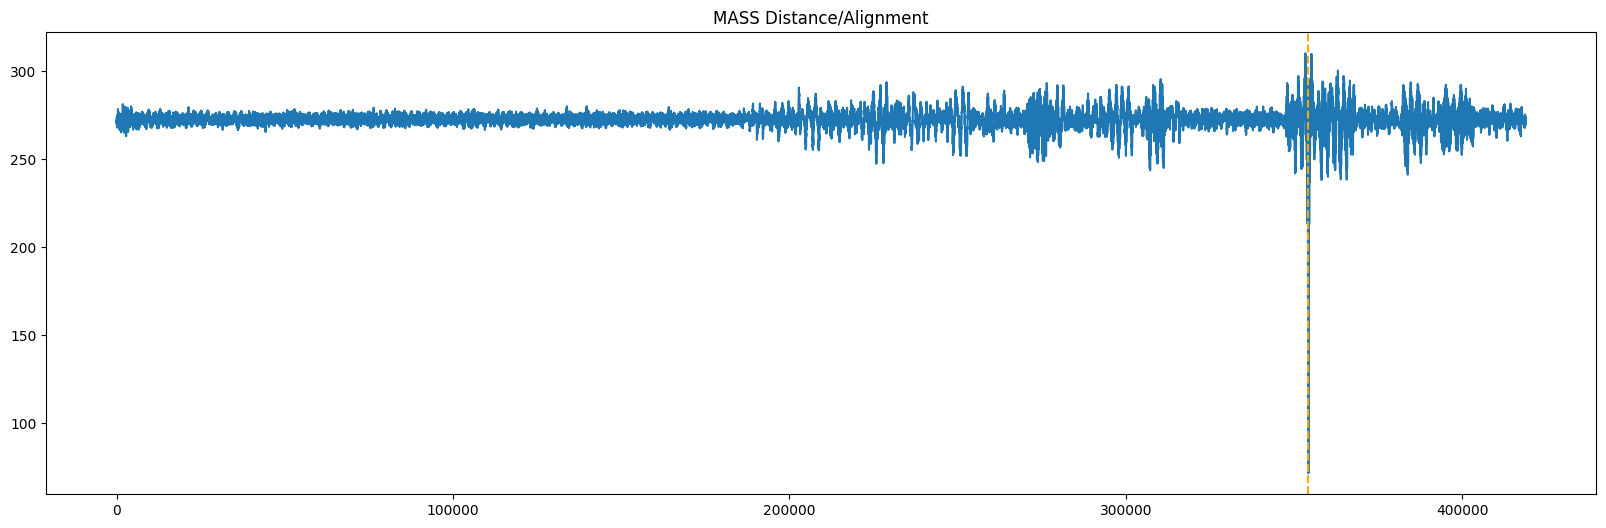

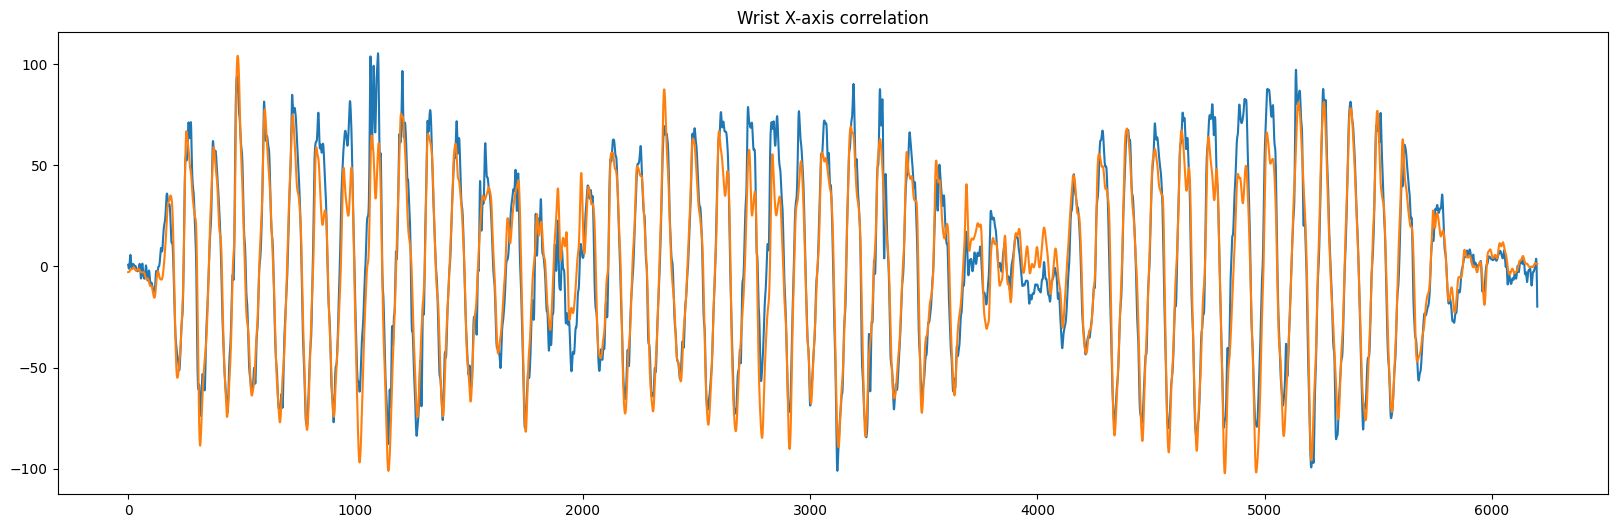

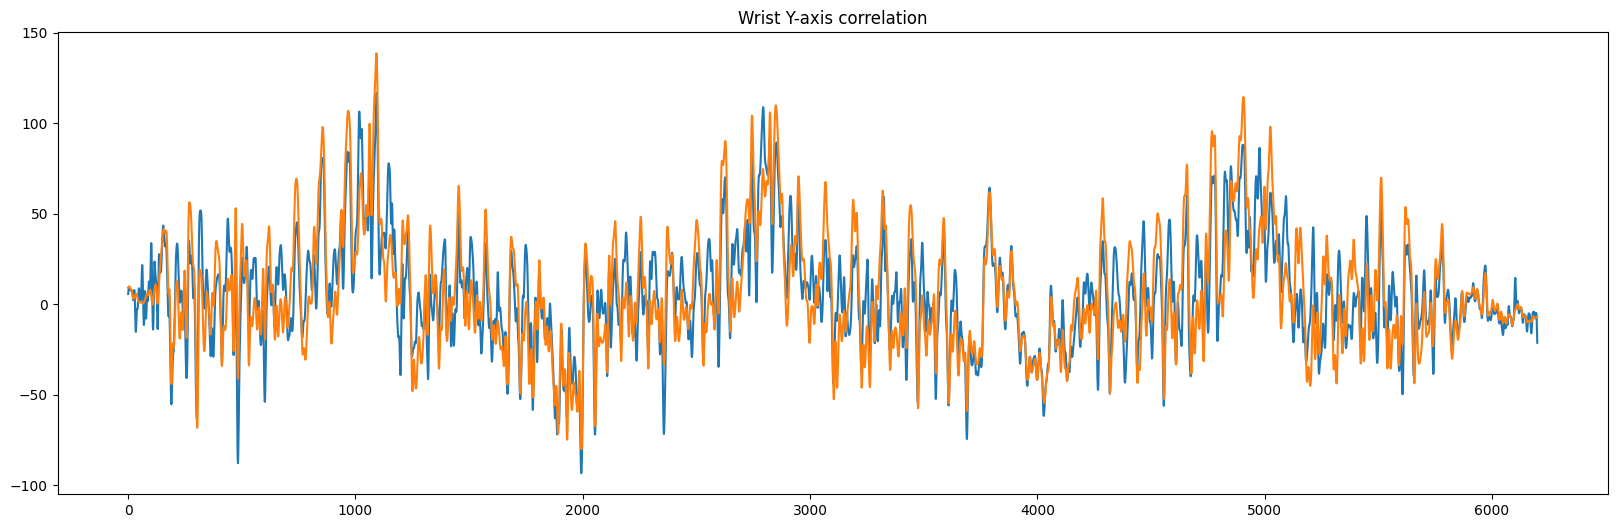

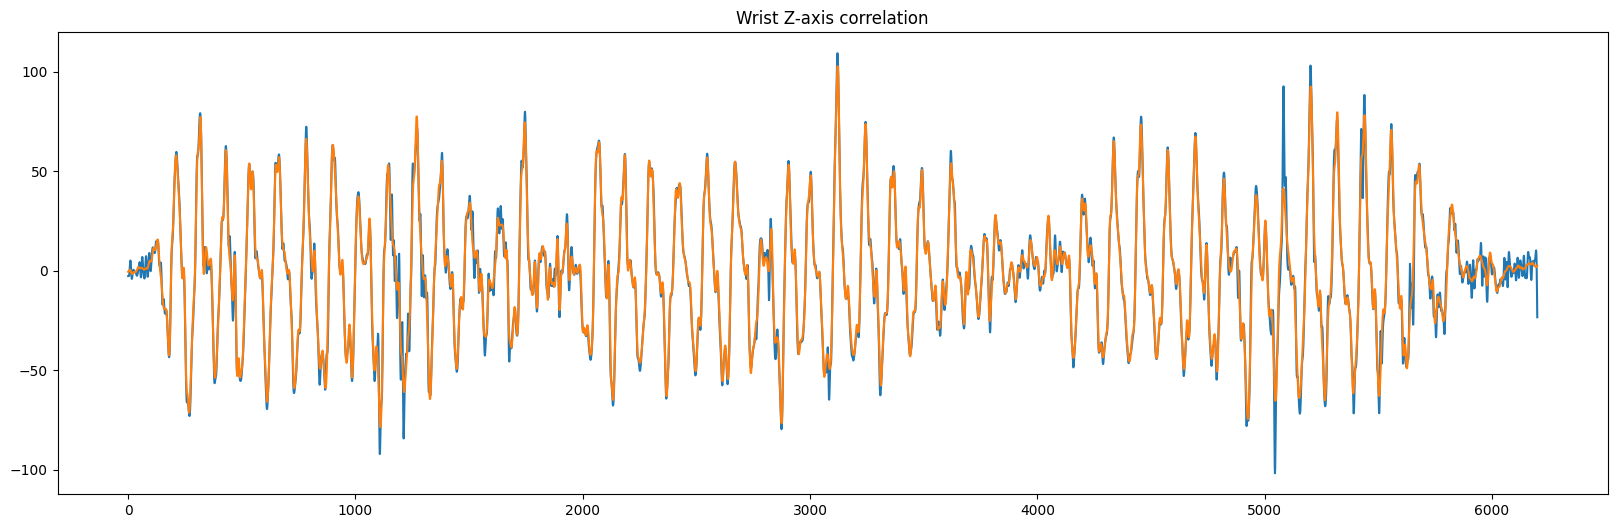

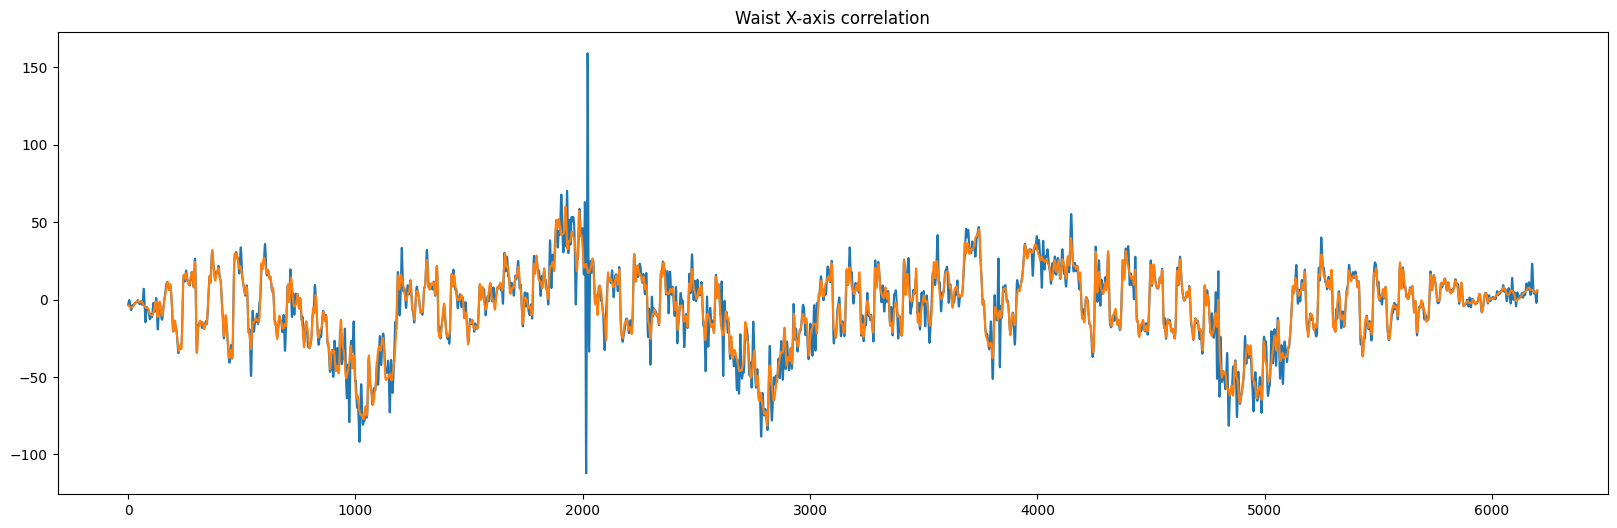

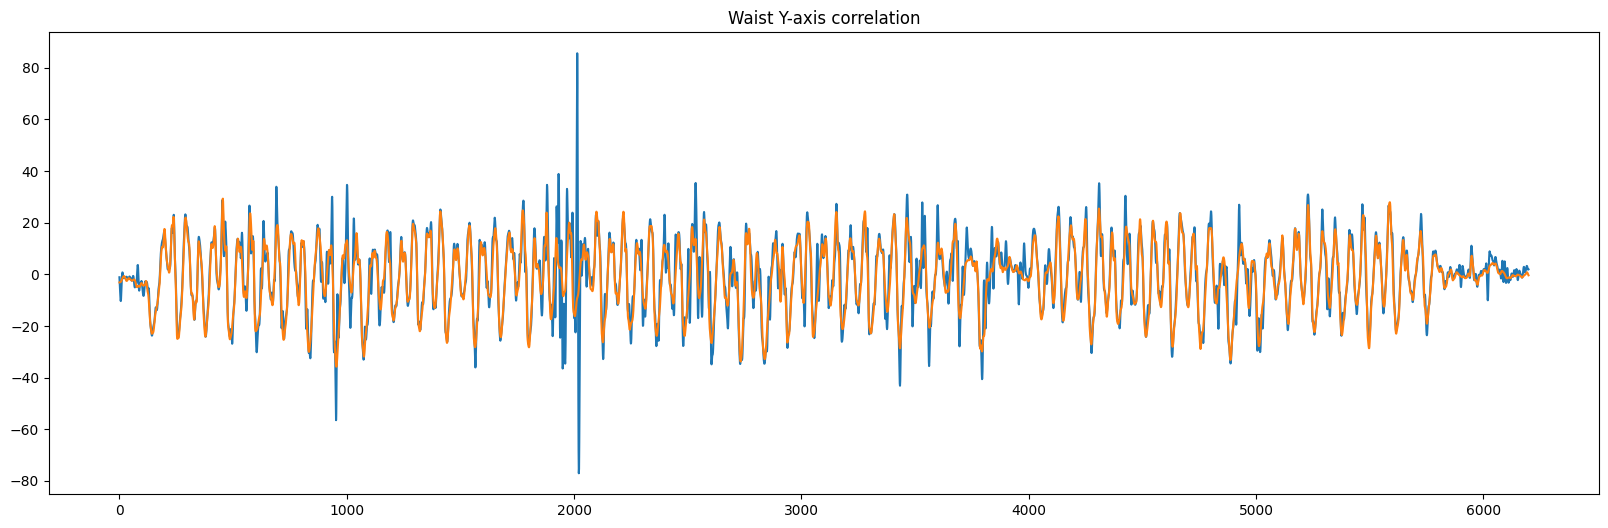

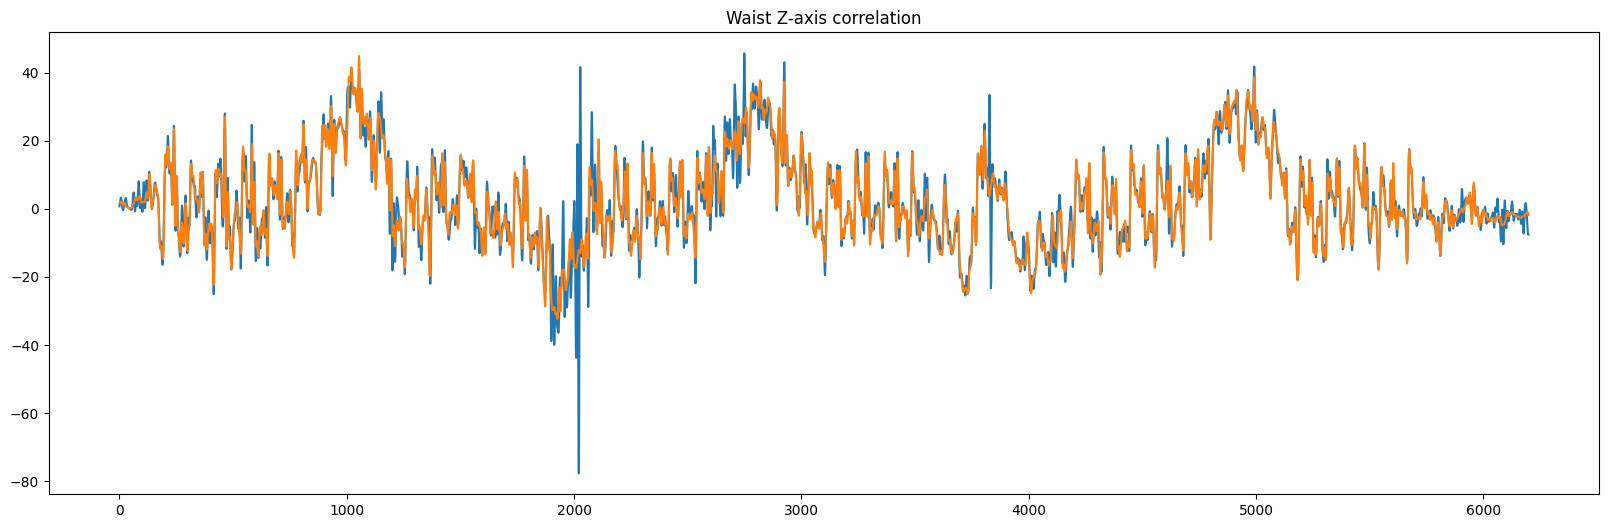


Number of NaNs = 0
Marker start time: [['TIME_STAMP' '2025-09-02, 14:26:05.805' 9170.6681521]]
marker_fs: 100.0
best_idx=np.int64(363213)
################## C:\Users\ac4jmi\Desktop\DMO4LNC\dmo4lnc-analysis\Dataset\PSP\864\Lab\\Motion Capture Data\TCCW.tsv ##################


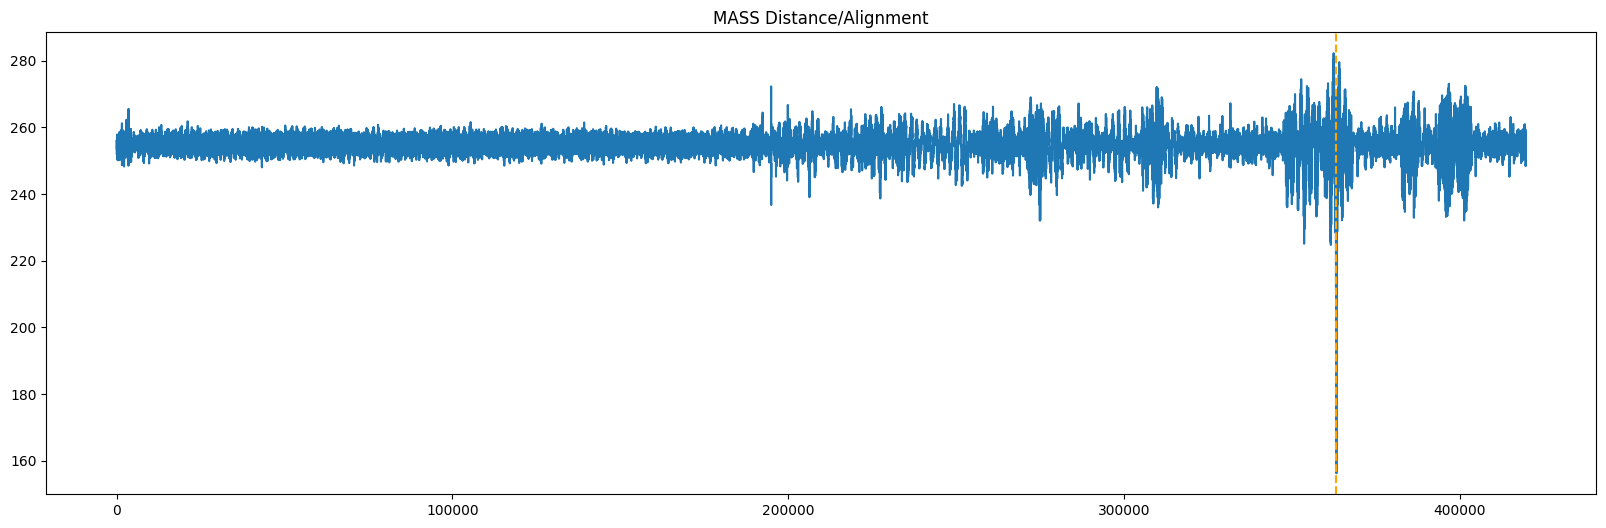

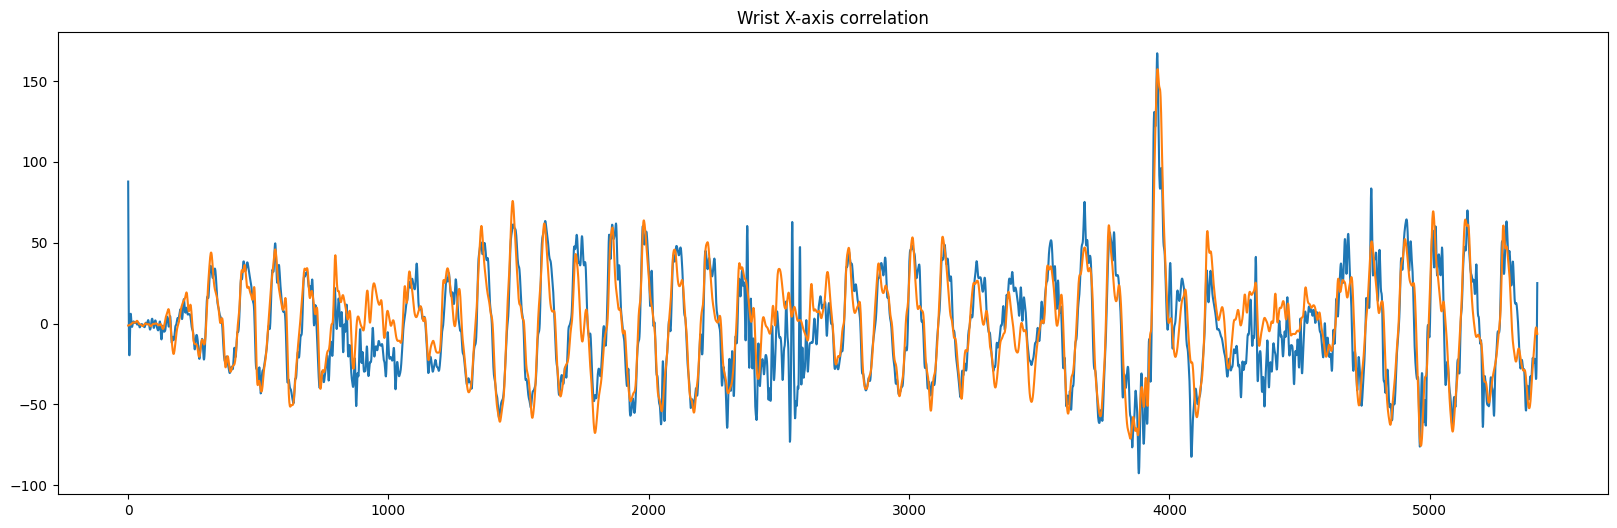

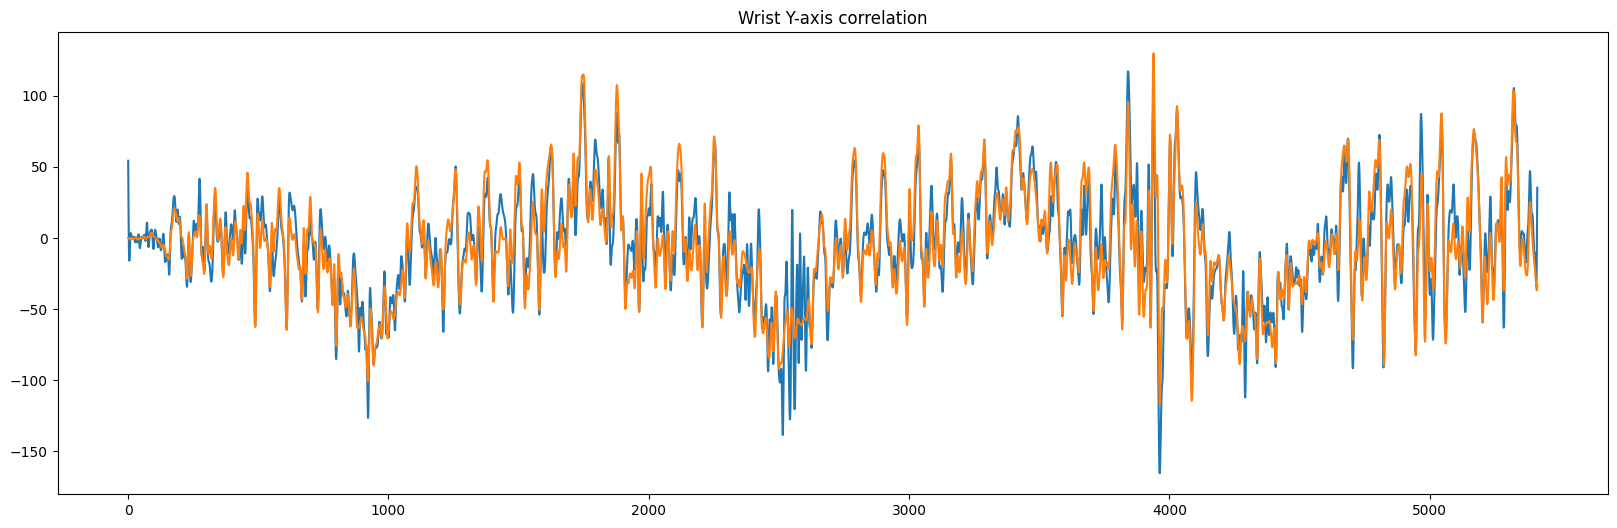

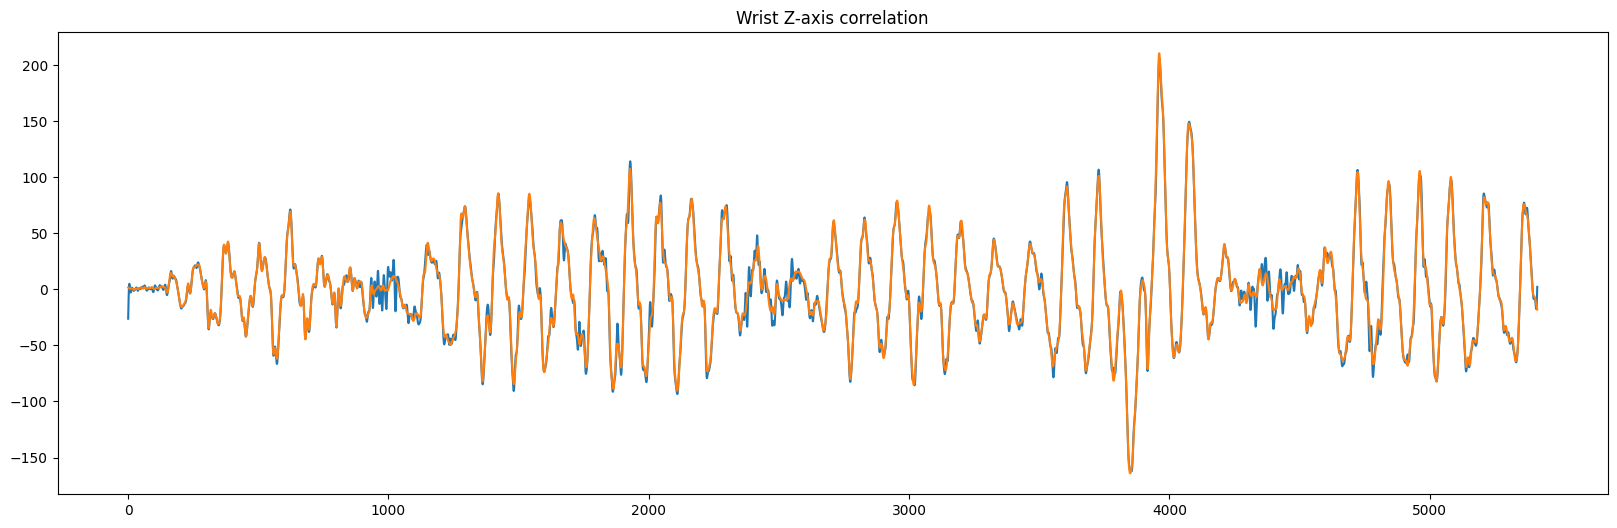

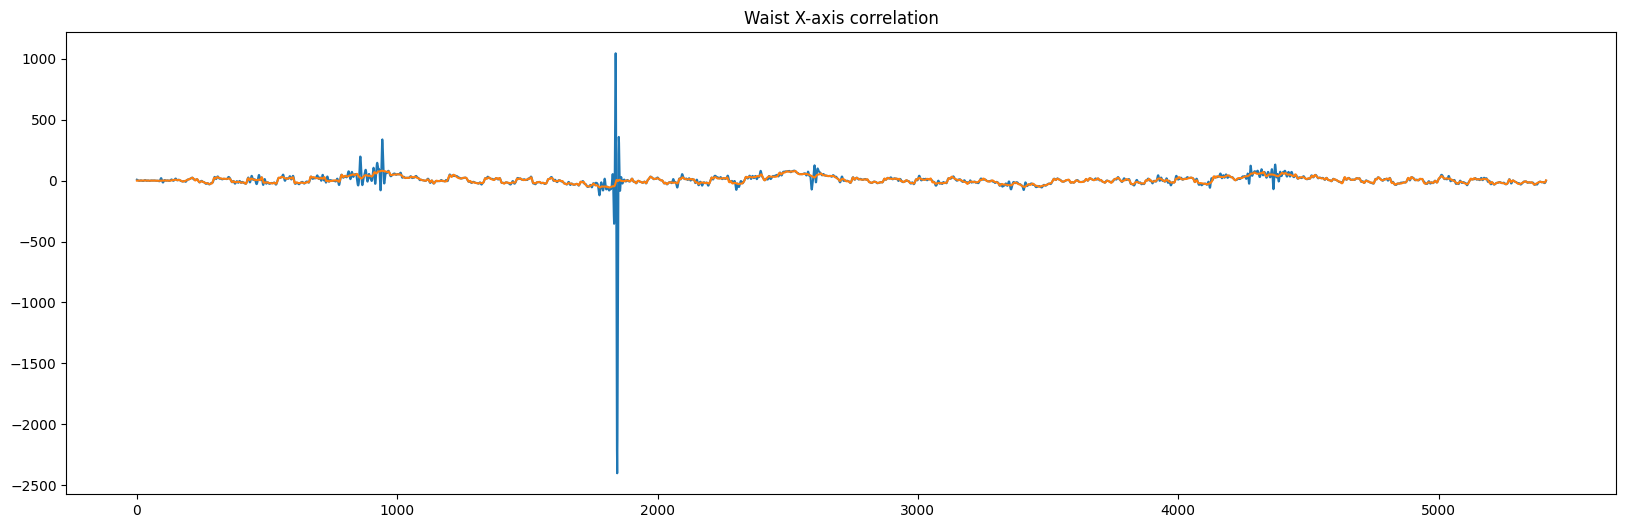

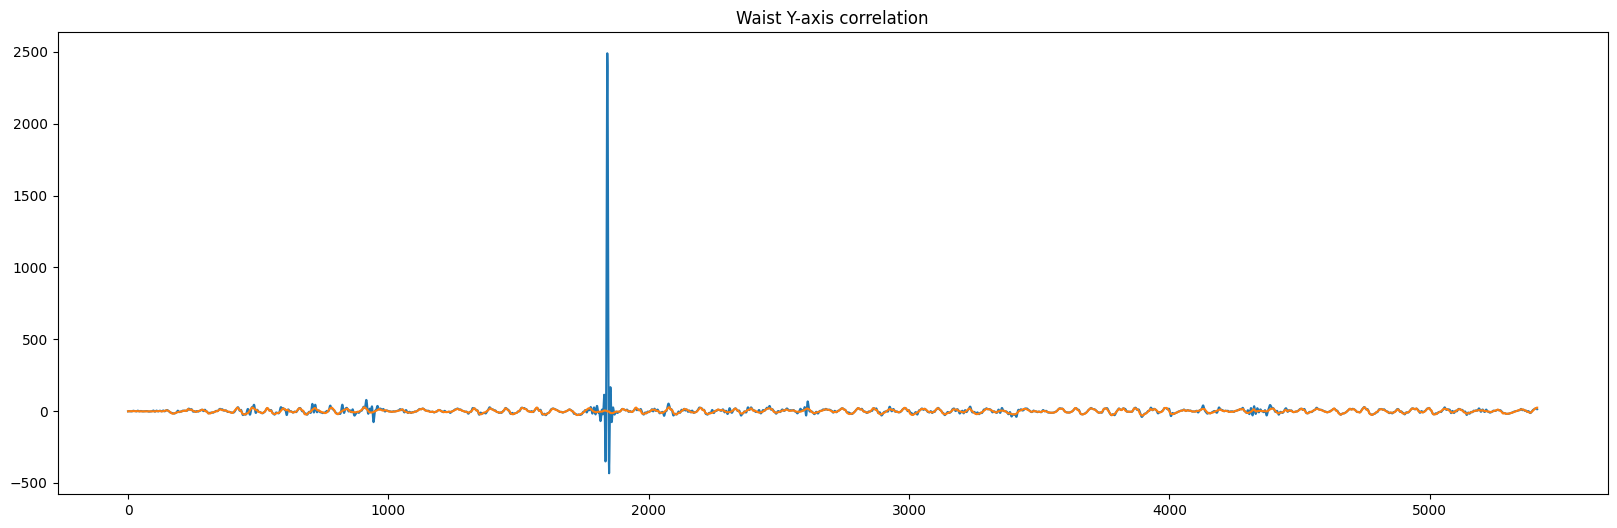

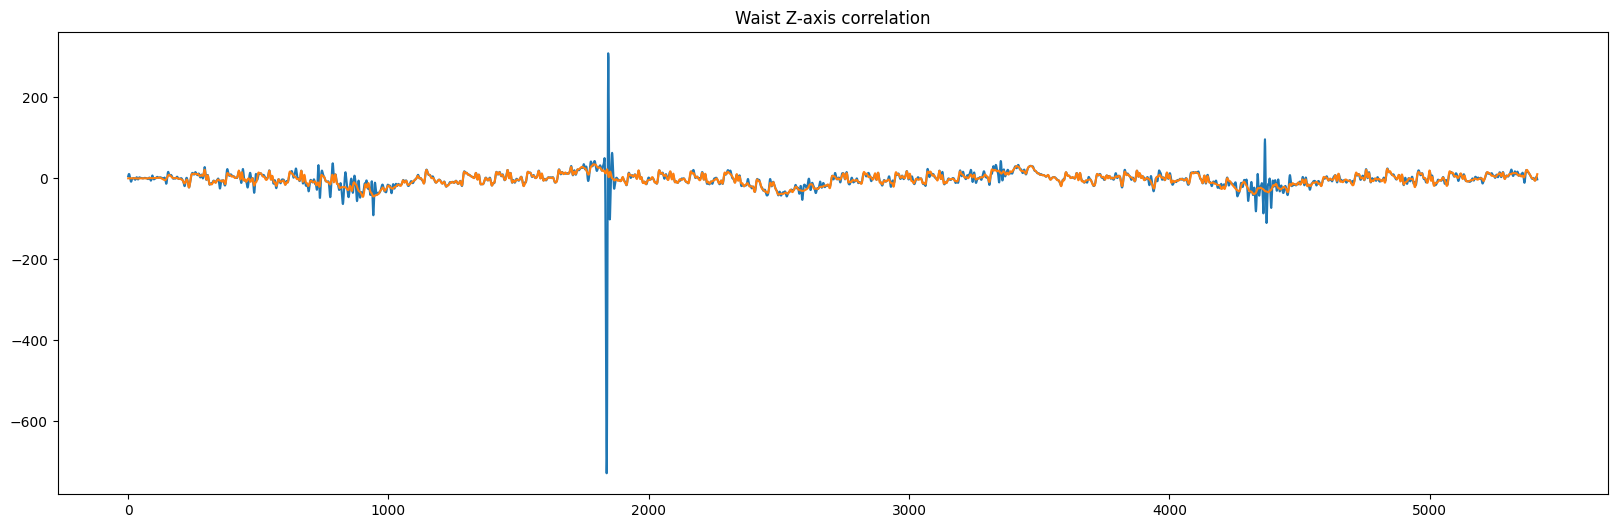


Number of NaNs = 0
Marker start time: [['TIME_STAMP' '2025-09-02, 14:31:56.565' 9521.428035]]
marker_fs: 100.0
best_idx=np.int64(398192)
################## C:\Users\ac4jmi\Desktop\DMO4LNC\dmo4lnc-analysis\Dataset\PSP\864\Lab\\Motion Capture Data\dumbbell.tsv ##################


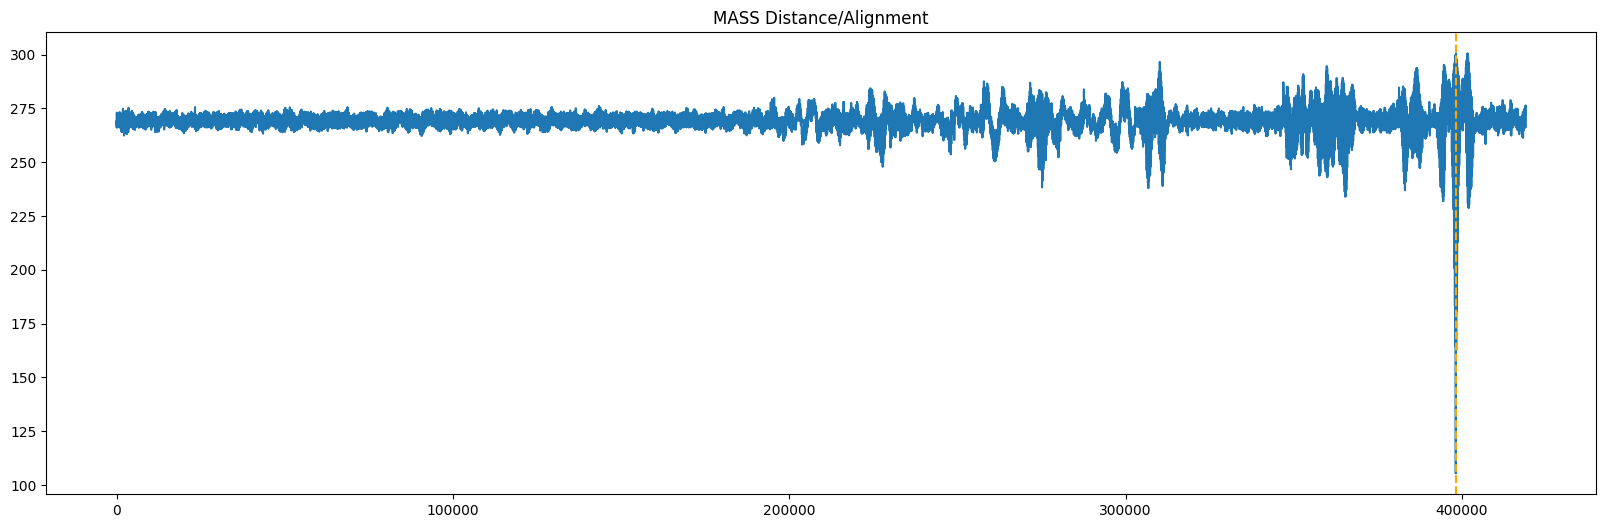

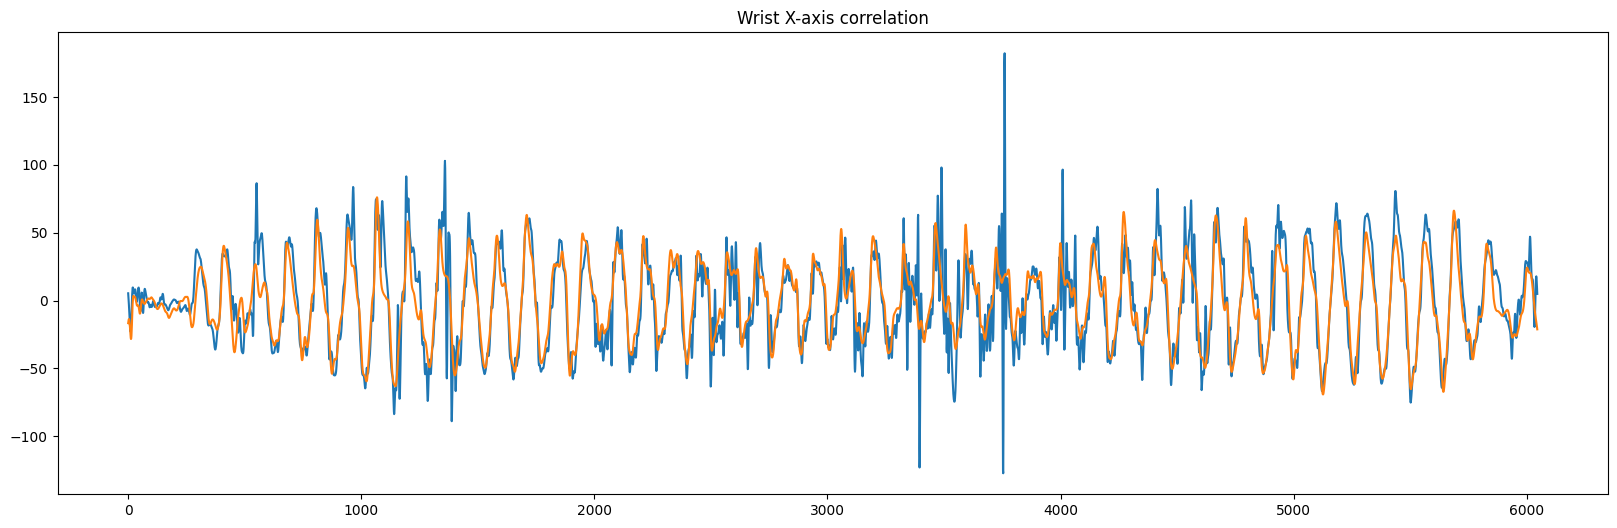

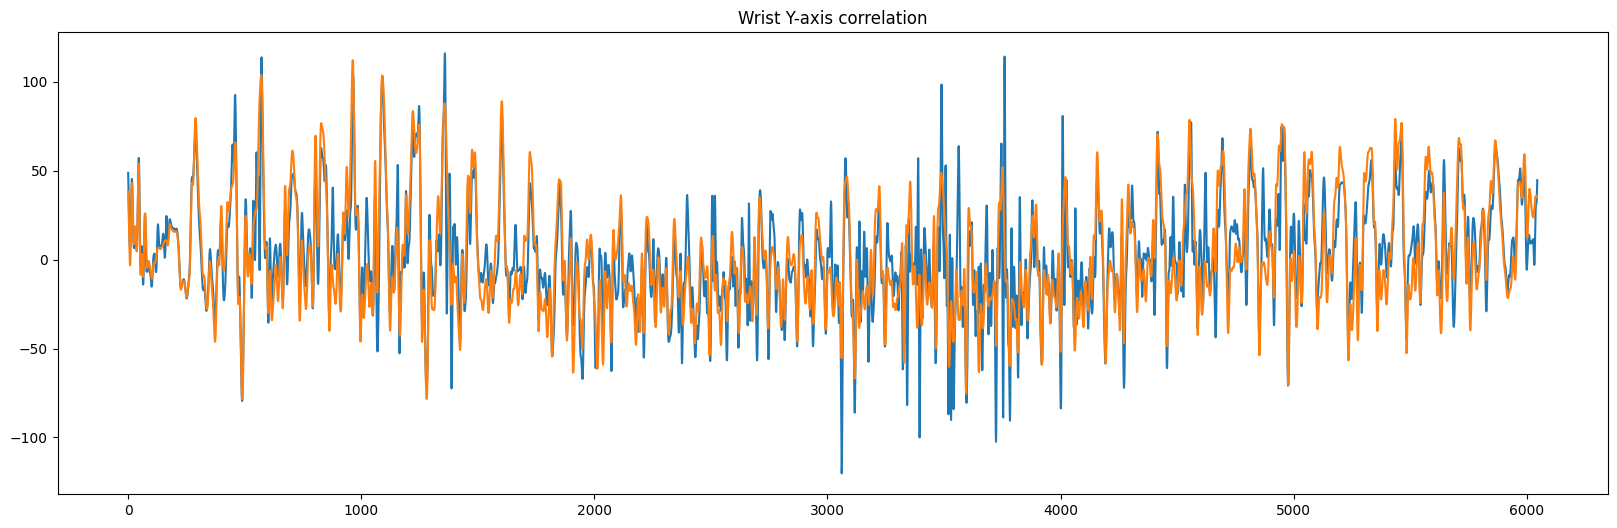

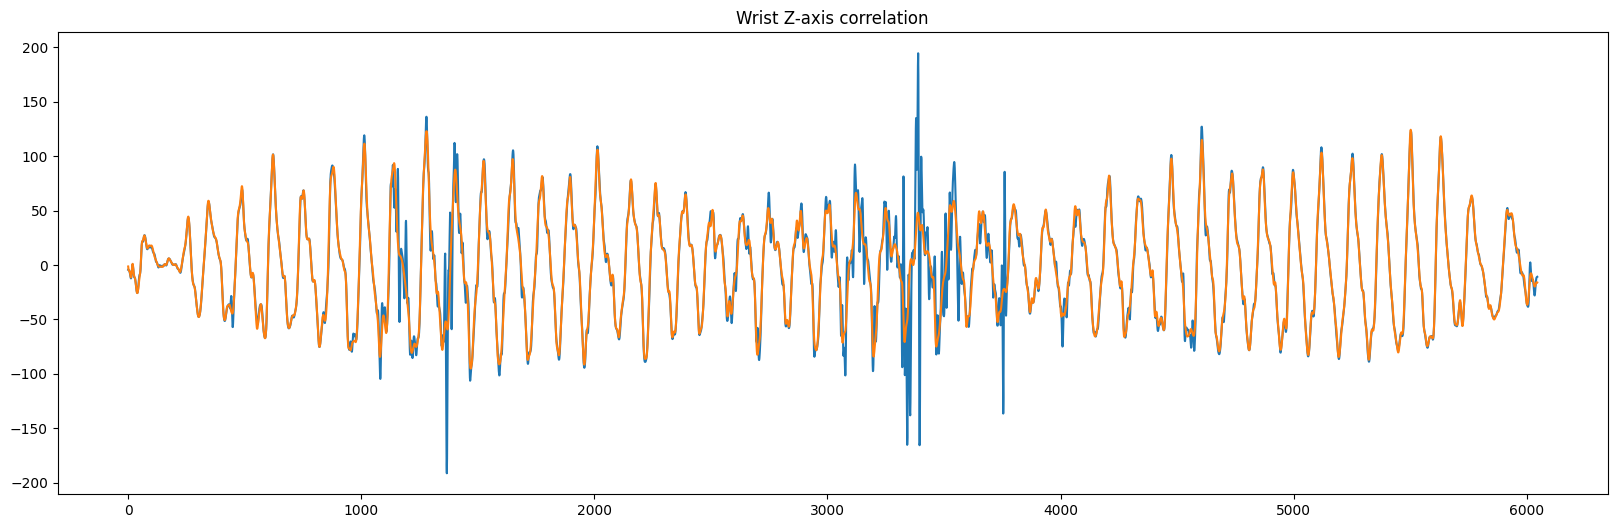

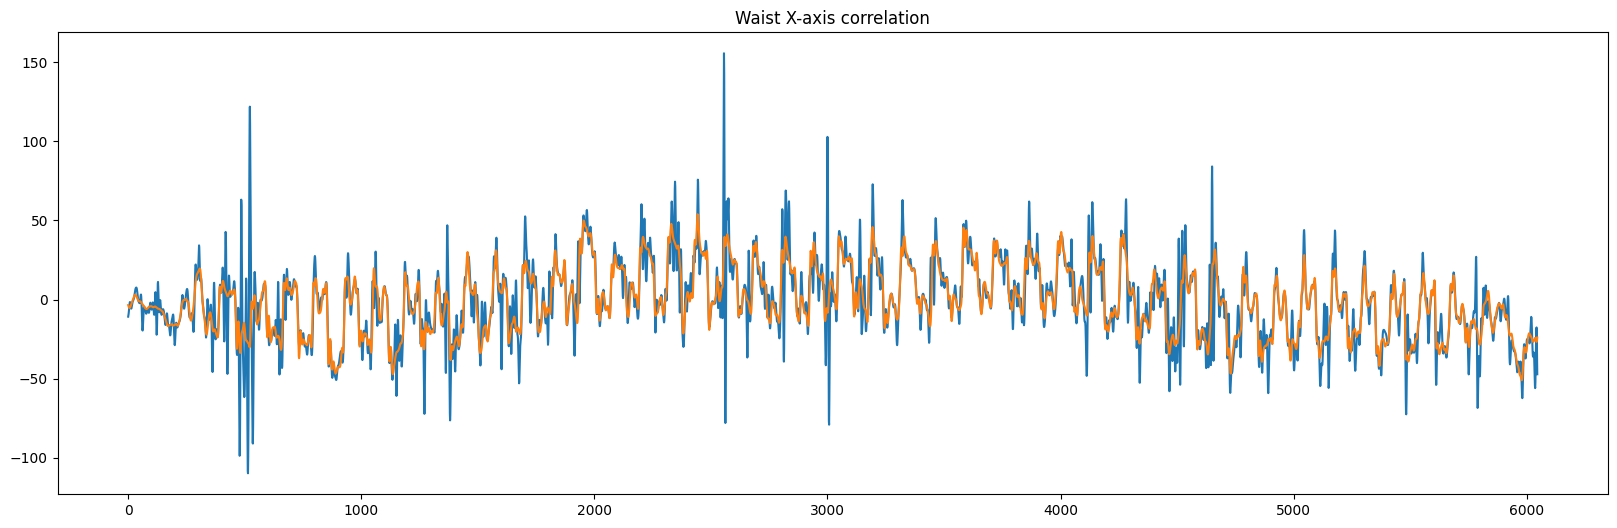

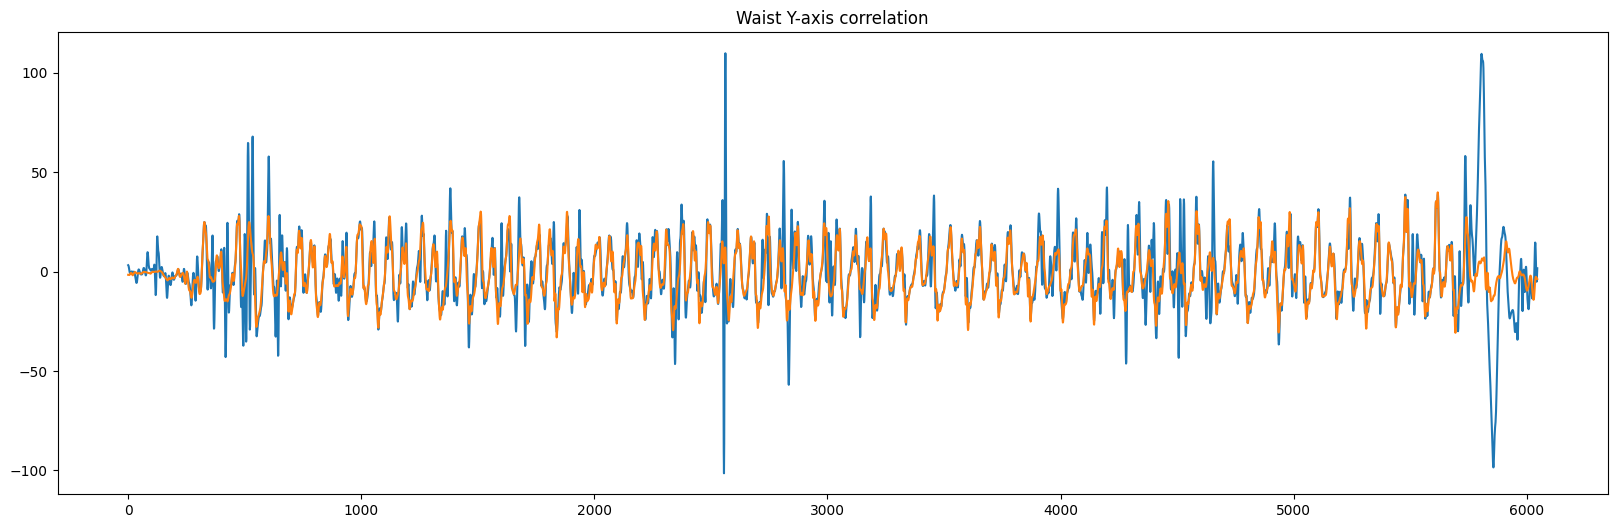

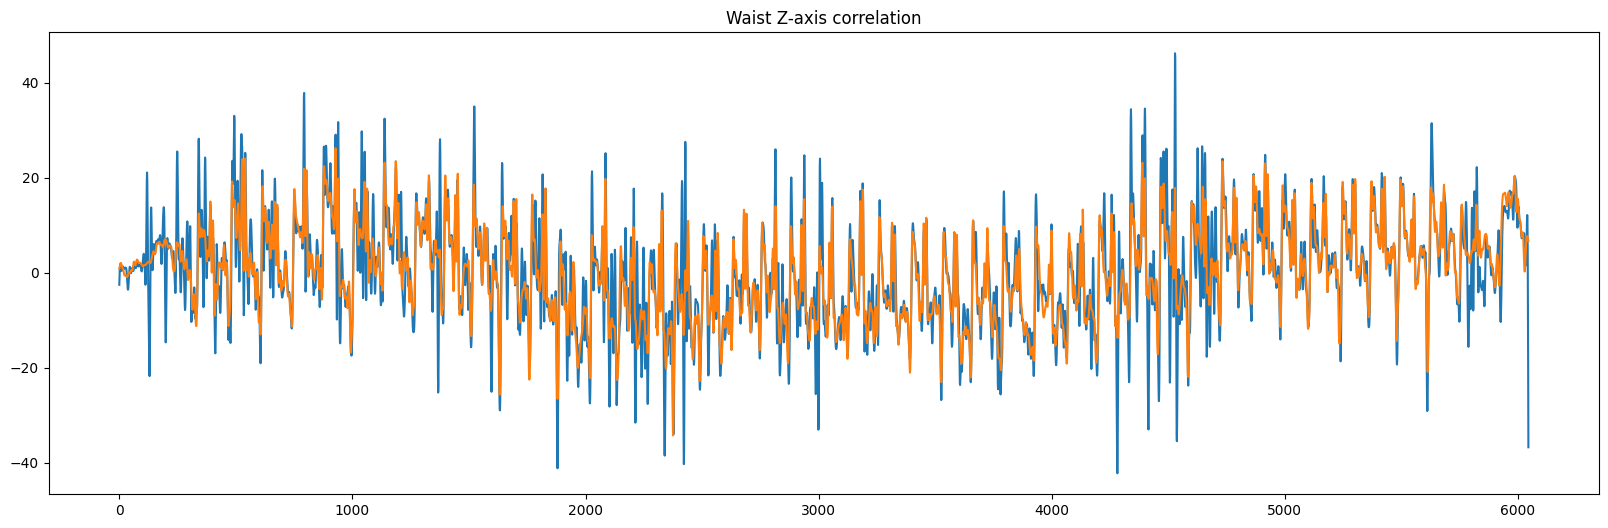

In [87]:
base_path = r"C:\Users\ac4jmi\Desktop\DMO4LNC\dmo4lnc-analysis\Dataset\PSP\864\Lab\\"
align_imu_mocap(base_path, prints = True)